# Twin-Delayed DDPG

Complete credit goes to this [awesome Deep Reinforcement Learning 2.0 Course on Udemy](https://www.udemy.com/course/deep-reinforcement-learning/) & EVA classes taken by Rohan Shravan for this exercise.

## Understanding Implementation
Because we can't run Kivy on Colab and because we don't have GPUs on our desktop, following is the strategy to train the network
* Load the sand image and move the coordinates (Vector) in env.step() for simulating car movement.
* State is captured by cropping a portion of sand image from car's position. And then rotating it in the direction of the car in such a way that car's orientation is horizontal i.e 0 degrees from x-axis. Also, car's distance and orientation is taken as part of state, which is normalized to be in range (-1, +1). This state is passed to Actor network
* Action is 1 dimensional, with its value being amount of angle the car should rotate

## State & Action Definition
States:
* Distance from Goal: This measures the distance between car and the goal. This is divided by maximum possible distance to normalize it to be in range (0,1). This gives network an idea of where the car is positioned with respect to the destination
* +Orientation: This is the orientation of the car with respect to the destination. This is divied by 180 degrees to normalize it in range (-1, 1). This gives network an idea of the direction of the destination
* -Orientation: Same as above, but negative of it. This for some reason improves network accuracy
* Cropped image of current postion as center. This image is rotated to be in the direction of car

Action:
* Scalar value indication the number of degrees car should rotate
Detailed information can be found here: https://github.com/ashxjain/AutoDrivingCarT3D/blob/master/README.md


## Importing the libraries
* Although Kivy is not used in Colab, we are installing it to use its `Vector` module for simulating Kivy environment

In [1]:
!pip install kivy

     |████████████████████████████████| 28.3MB 112kB/s 
  Created wheel for Kivy-Garden: filename=Kivy_Garden-0.1.4-cp36-none-any.whl size=4532 sha256=4ce91a6e29d6cea16e27abcdf83b2726a5808288867a510cdc1965e5cf6ae646
  Stored in directory: /root/.cache/pip/wheels/e5/09/36/4bec048252175b6aa7ba75441cbeed8f31a0bea37abedcfed0
Successfully built Kivy-Garden


In [0]:
%matplotlib notebook

import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import PIL
import matplotlib.patches as patches
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from collections import deque
from PIL import Image as PILImage

# Define Replay Memory
* This is a fixed size array storing multiple experiences.
* An experience (aka transition) is defined by the following:
  * s_a, s_b: current state in which the agent is
  * a: action the agent takes to go to next state
  * s'_a, s'_b: new state agent reaches after taking an action (a)
  * r: reward an agent receive for going from state (s) to state (s') by taking action (a)
* **Note about states:** Since here we have heterogenous state i.e. cropped image & scalar values of (car's distance from goal, +orientation, -orientation), s is split into s_a & s_b. Similarly, next states is split into s'_a & s'_b
* Initially, agent plays with the environment randomly and fills in replay memory.
* Then during training, a batch of experiences is sampled randomly to train the agent.
* Also this memory is simultaneously filled as and when agent explores the environment.
* If memory is full, then first entry is removed and new entry is added.



In [0]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      self.storage[int(self.ptr)] = transition
      self.ptr = (self.ptr + 1) % self.max_size
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    ind = np.random.randint(0, len(self.storage), size=batch_size)
    batch_states_a, batch_states_b, batch_next_states_a, batch_next_states_b, batch_actions, batch_rewards, batch_dones = [], [], [], [], [], [], []
    for i in ind: 
      state_a, state_b, next_state_a, next_state_b, action, reward, done = self.storage[i]
      batch_states_a.append(np.array(state_a, copy=False))
      batch_states_b.append(np.array(state_b, copy=False))
      batch_next_states_a.append(np.array(next_state_a, copy=False))
      batch_next_states_b.append(np.array(next_state_b, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states_a), np.array(batch_states_b), np.array(batch_next_states_a), np.array(batch_next_states_b), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

* Fetch device information. This is very useful to speed up network training/inference by using GPU when available. If GPU is not available then, CPU is used

In [0]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Network Architecture
* We build one neural network for the Actor model and one neural network for the Actor target
* We use MobileNet for this implementation as we don't need very complex network and also the network should have good speed
* Below also hosts common functions used to build Actor and Critic networks
* conv_bn: does simple conv2d with kernel size 3x3 and padding 1
* conv_dw: does depthwise convolution with padding 1
* state_model: common state network used for both Actor and Critic networks

In [0]:
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True)
    )

def conv_dw(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, inp, 3, stride, 1, groups=inp, bias=False),
        nn.BatchNorm2d(inp),
        nn.ReLU(inplace=True),

        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU(inplace=True),
    )

def state_model():
    return nn.Sequential(
            # CHW: 1, 32, 32
            conv_bn(  1,  32, 1), # 32, 32, 32
            conv_dw( 32,  32, 1), # 32, 32, 32
            conv_dw( 32,  16, 2), # 16, 16, 16
            conv_dw( 16,  16, 1), # 16, 16, 16
            conv_dw( 16,  16, 2), # 16,  8,  8
            conv_dw( 16,  16, 1), # 16,  8,  8
            nn.AvgPool2d(8),
        )

# Creating the architecture of the Neural Network
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.model = state_model()
        self.fc1 = nn.Linear(16 + state_dim[1], 100)
        self.fc2 = nn.Linear(100, action_dim)
        self.max_action = max_action

    def forward(self, xa, xb):
        x = self.model(xa)
        x = x.view(-1, 16)
        x = torch.cat([x, xb], 1)
        x = F.relu(self.fc1(x))
        x = self.max_action * torch.tanh(self.fc2(x))
        return x

In [0]:
from torchsummary import summary

#model = Actor((32, 3),1,10).to(device)
#summary(model, input_size=[(1, 32, 32), (3,)])

* We build two neural networks for the two Critic models and two neural networks for the two Critic targets
* Uses common functions defined above
* State and Actor inputs are concatenated before FC (fully connected) layers

In [0]:
# Creating the architecture of the Neural Network
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Defining the first Critic neural network
        self.c1_model = state_model()
        self.c1_fc1 = nn.Linear(16 + state_dim[1] + action_dim, 100)
        self.c1_fc2 = nn.Linear(100, 1)

        # Defining the second Critic neural network
        self.c2_model = state_model()
        self.c2_fc1 = nn.Linear(16 + state_dim[1] + action_dim, 100)
        self.c2_fc2 = nn.Linear(100, 1)

    def forward(self, xa, xb, u):
      # Forwad-Propagation on the first Critic Neural Network
      x1 = self.c1_model(xa)
      x1 = x1.view(-1, 16)
      x1 = torch.cat([x1, xb, u], 1)
      x1 = F.relu(self.c1_fc1(x1))
      x1 = self.c1_fc2(x1)

      # Forward-Propagation on the second Critic Neural Network
      x2 = self.c2_model(xa)
      x2 = x2.view(-1, 16)
      x2 = torch.cat([x2, xb, u], 1)
      x2 = F.relu(self.c2_fc1(x2))
      x2 = self.c2_fc2(x2)

      return x1, x2

    def Q1(self, xa, xb, u):
      x1 = self.c1_model(xa)
      x1 = x1.view(-1, 16)
      x1 = torch.cat([x1, xb, u], 1)
      x1 = F.relu(self.c1_fc1(x1))
      x1 = self.c1_fc2(x1)
      return x1

* Below torch summary fails to calculate parameters
* This is a known torchsummary issue

In [0]:
#model = Critic((32, 3),1).to(device)
#summary(model, input_size=[(1, 32, 32), (3,), (1,)])

## Define Training Process

In [0]:
# Building the whole Training Process into a class

class T3D(object):
  
  def __init__(self, state_dim, action_dim, max_action):
    self.max_action = torch.Tensor(max_action).to(device)
    self.actor = Actor(state_dim, action_dim, self.max_action).to(device)
    self.actor_target = Actor(state_dim, action_dim, self.max_action).to(device)
    self.actor_target.load_state_dict(self.actor.state_dict())
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters())
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_target = Critic(state_dim, action_dim).to(device)
    self.critic_target.load_state_dict(self.critic.state_dict())
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters())
    
  def select_action(self, state):
    state_a, state_b = state[0], state[1]
    state_a = state_a.unsqueeze(0).to(device)
    state_b = state_b.unsqueeze(0).to(device)
    return self.actor(state_a, state_b).cpu().data.numpy().flatten()

  def train(self, replay_buffer, iterations, batch_size=100, discount=0.99, tau=0.005, policy_noise=0.2, noise_clip=0.5, policy_freq=2):
    
    for it in range(iterations):
      
      # We sample a batch of transitions (s, s', a, r) from the memory
      batch_states_a, batch_states_b, batch_next_states_a, batch_next_states_b, batch_actions, batch_rewards, batch_dones = replay_buffer.sample(batch_size)
      state_a = torch.Tensor(batch_states_a).to(device)
      state_b = torch.Tensor(batch_states_b).to(device)
      next_state_a = torch.Tensor(batch_next_states_a).to(device)
      next_state_b = torch.Tensor(batch_next_states_b).to(device)
      action = torch.Tensor(batch_actions).to(device)
      reward = torch.Tensor(batch_rewards).to(device)
      done = torch.Tensor(batch_dones).to(device)
      
      # From the next state s', the Actor target plays the next action a'
      next_action = self.actor_target(next_state_a, next_state_b)
      # We add Gaussian noise to this next action a’ and we clamp it in a range of values supported by the environment
      noise = torch.Tensor(batch_actions).data.normal_(0, policy_noise).to(device)
      noise = noise.clamp(-noise_clip, noise_clip)
      next_action = (next_action + noise).clamp(-self.max_action[0], self.max_action[0])
      # The two Critic targets take each the couple (s', a') as input and return two Q-values Qt1(s',a') and Qt2(s',a') as outputs
      target_Q1, target_Q2 = self.critic_target(next_state_a, next_state_b, next_action)
      
      # We keep the minimum of these two Q-values: min(Qt1, Qt2)
      target_Q = torch.min(target_Q1, target_Q2)
      
      # We get the final target of the two Critic models, which is: Qt = r + gamma * min(Qt1, Qt2), where gamma is the discount factor
      target_Q = reward + ((1 - done) * discount * target_Q).detach()
      
      # The two Critic models take each the couple (s, a) as input and return two Q-values Q1(s,a) and Q2(s,a) as outputs
      current_Q1, current_Q2 = self.critic(state_a, state_b, action)
      
      # We compute the loss coming from the two Critic models: Critic Loss = MSE_Loss(Q1(s,a), Qt) + MSE_Loss(Q2(s,a), Qt)
      critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)
      
      # We backpropagate this Critic loss and update the parameters of the two Critic models with a SGD optimizer
      self.critic_optimizer.zero_grad()
      critic_loss.backward()
      self.critic_optimizer.step()
      
      # Once every two iterations, we update our Actor model by performing gradient ascent on the output of the first Critic model
      if it % policy_freq == 0:
        actor_loss = -self.critic.Q1(state_a, state_b, self.actor(state_a, state_b)).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        # Still once every two iterations, we update the weights of the Actor target by polyak averaging
        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        
        # Still once every two iterations, we update the weights of the Critic target by polyak averaging
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
          target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
  
  # Making a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_critic.pth' % (directory, filename))
  
  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_critic.pth' % (directory, filename)))

## We create a file name for the two saved models: the Actor and Critic models

In [10]:
env_name = "AutoDrivingCarModels" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
save_models = True # Boolean checker whether or not to save the pre-trained model

file_name = "%s_%s_%s" % ("T3D", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))
print ("---------------------------------------")

---------------------------------------
Settings: T3D_AutoDrivingCarModels_0
---------------------------------------


## We create a folder inside which will be saved the trained models

In [0]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

## Download the map image
Although a proper city map is the main image to drive the car on, but a mask is used here as it becomes simpler to train

In [12]:
!wget -O MASK1.png https://drive.google.com/uc\?export\=view\&id\=1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3

--2020-05-07 16:52:46--  https://drive.google.com/uc?export=view&id=1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3
Resolving drive.google.com (drive.google.com)... 172.217.194.100, 172.217.194.138, 172.217.194.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.194.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ot1gn3olagqket84bv092q9ap8c8u4al/1588870350000/09305796575597883680/*/1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3?e=view [following]
--2020-05-07 16:52:47--  https://doc-0c-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ot1gn3olagqket84bv092q9ap8c8u4al/1588870350000/09305796575597883680/*/1eHsgsEdvdUMZjSR5XUhA2kFgdPK3qSN3?e=view
Resolving doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.googleusercontent.com)... 74.125.68.132, 2404:6800:4003:c02::84
Connecting to doc-0c-60-docs.googleusercontent.com (doc-0c-60-docs.

# Define helper functions
* Below are helper functions to crop the image and perform rotation on it


In [0]:
%matplotlib inline

from PIL import Image, ImageOps
import matplotlib.markers as mmarkers

def center_crop_img(img, x, y, crop_size):
  max_x, max_y = img.size
  pad_left, pad_right, pad_bottom, pad_top = 0, 0, 0, 0
  start_x = x - int(crop_size/2)
  start_y = y - int(crop_size/2)
  end_x = x + int(crop_size/2)
  end_y = y + int(crop_size/2)
  if start_x < 0:
      pad_left = -start_x
      start_x = 0
  if end_x >= max_x:
      pad_right = end_x - max_x
  if start_y < 0:
      pad_top = -start_y
      start_y = 0
  if end_y >= max_y:
      pad_bottom = end_y - max_y
  padding = (int(pad_left), int(pad_top), int(pad_right), int(pad_bottom))
  new_img = ImageOps.expand(img, padding, fill=255)
  crop_img = new_img.crop((start_x, start_y, start_x+crop_size, start_y+crop_size))

  return crop_img

def rotate_img(img, angle):
  im1 = img.convert('RGBA')
  rot = im1.rotate(angle)
  # a white image same size as rotated image
  fff = Image.new('RGBA', rot.size, (255,)*4)
  # create a composite image using the alpha layer of rot as a mask
  return Image.composite(rot, fff, rot).convert('L')

def show_img(ax, img, title=""):
  np_img = np.asarray(img)/255
  np_img = np_img.astype(int)
  ax.imshow(np_img, cmap='gray', vmin=0, vmax=1)
  if title != "":
    ax.set_title(title)

## Create the environment
* We simulate Kivy environment here. As Kivy doesn't do much apart from Graphics
* We maintain x,y position and car's angle. This is rotated based on action
* Action here is one-dimensional, which is the amount of degrees the car should rotate
* If x,y position is on sand, we set a small velocity, else a slightly high velocity
* Our state here corresponds to the cropped portion of current postion as center. This image is rotated to be in the direction of car. This was our network understands car's orientation
* Cropping here is done differently. If we directly crop and rotate the image, we may loose information from the edges. Hence we do the following:
  * Crop a larger portion of image
  * Rotate it to make the cropped image in the direction of car's orientation
  * Then crop it to required size
* `reset` function picks a random coordinates on road and a random angle and returns state

In [14]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

import matplotlib.patches as patches
import matplotlib.animation as animation
import matplotlib.markers as mmarkers
import numpy as np

from PIL import Image as PILImage
from kivy.vector import Vector
from collections import Counter


class CarEnv(object):
    def __init__(self, filename):
        self.filename = filename
        img = PILImage.open(self.filename).convert('L')
        self.sand = np.asarray(img)/255
        self.sand = self.sand.astype(int)
        self.max_y, self.max_x = self.sand.shape
        self.pos = Vector(int(self.max_x/2), int(self.max_y/2))
        self.angle = Vector(10,0).angle(self.pos)
        self.velocity = Vector(6, 0)
        self.wall_padding = 5
        self.max_angle = 20
        self.max_action = [self.max_angle]
        self.crop_size = 100
        self.goal_iter = 0
        self.goals = [Vector(1890, 150), Vector(140, 380)]
        self.last_distance = 0
        self.state_dim = (32, 3)
        self.action_dim = (1,)
        self._max_episode_steps = 5000
        # track rewards distribution
        self.rewards_distribution = Counter()

        self.target = Vector(335, 178)
        self.max_distance = 1574.
      
    def seed(self, seed):
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def reset(self):
        self.angle = np.random.randint(low=-180, high=180)
        onsand = True
        while onsand:
          self.pos.x = np.random.randint(low=self.wall_padding, high=self.max_x-self.wall_padding)
          self.pos.y = np.random.randint(low=self.wall_padding, high=self.max_y-self.wall_padding)
          if self.sand[int(self.pos.y),int(self.pos.x)] == 0:
            onsand = False
        self.velocity = Vector(0.5, 0).rotate(self.angle)
        return self.get_state()
    
    def random_action(self):
        rotation = np.random.uniform(low=-self.max_angle, high=self.max_angle)
        return (rotation,)
    
    def step(self, action):
        rotation = action[0]
        self.angle += rotation

        if self.sand[int(self.pos.y),int(self.pos.x)] > 0:
            self.velocity = Vector(0.5, 0).rotate(self.angle)
        else:
            self.velocity = Vector(2.0, 0).rotate(self.angle)

        self.pos.x += self.velocity.x
        self.pos.y += -self.velocity.y
        reward = 0
        done = False

        distance = self.pos.distance(self.target)
        if self.sand[int(self.pos.y),int(self.pos.x)] > 0:
          reward = -1
          tag = "sand"
        else:
          if distance < 20:
            tag = "goal"
            reward = 10
            done = True
          elif distance < self.last_distance:
            tag = "towards"
            reward = 0.1
          else:
            tag = "away"
            reward = -0.5

        wall_reward = -10
        if self.pos.x < self.wall_padding:
            self.pos.x = self.wall_padding
            reward = wall_reward
            tag = "wall"
            done = True
        if self.pos.x > self.max_x - self.wall_padding:
            self.pos.x = self.max_x - self.wall_padding
            reward = wall_reward
            tag = "wall"
            done = True
        if self.pos.y < self.wall_padding:
            self.pos.y = self.wall_padding
            reward = wall_reward
            tag = "wall"
            done = True
        if self.pos.y > self.max_y - self.wall_padding:
            self.pos.y = self.max_y - self.wall_padding
            reward = wall_reward
            tag = "wall"
            done = True

        self.last_distance = distance
        self.rewards_distribution[tag] += 1
        return self.get_state(), reward, done
    
    def render(self):
        # Create figure and axes
        fig, ax = plt.subplots(1, 5, figsize=(30, 6))

        # Display the image
        ax[0].imshow(self.sand, cmap='gray', vmin=0, vmax=1)
        # Create a Rectangle patch
        rect = patches.Rectangle(
            (self.pos.x - int(self.crop_size/2), self.pos.y - int(self.crop_size/2)),
            self.crop_size, self.crop_size,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        # Add the patch to the Axes
        ax[0].add_patch(rect)
        ax[0].set_title("x=%d,y=%d,angle=%d" % (self.pos.x, self.pos.y, self.angle))
        
        marker = mmarkers.MarkerStyle(marker="$ \\rightarrow$")
        marker._transform = marker.get_transform().rotate_deg(self.angle)
        ax[0].scatter(self.pos.x, self.pos.y, s=50, c='red', marker=marker)
        self.get_state(ax)
        plt.show()
        
    def get_state(self, ax=None):
        distance = self.pos.distance(self.target)/self.max_distance
        goal_vector = self.target - self.pos
        goal_vector = Vector(goal_vector.x, self.max_y - goal_vector.y)
        velocity = Vector(2, 0).rotate(self.angle)
        orientation = Vector(*velocity).angle(goal_vector)/180.

        resize = T.Compose([T.ToPILImage(),
                            T.Resize(self.state_dim[0], interpolation=Image.CUBIC),
                            T.ToTensor()])
        
        img = Image.open(self.filename).convert('L')

        # If we directly crop and rotate the image, we may loose information
        # from the edges. Hence we do the following:
        #   * Crop a larger portion of image
        #   * Rotate it to make the cropped image in the direction
        #     of car's orientation
        #   * Then crop it to required size
        crop_img = center_crop_img(img, self.pos.x, self.pos.y, self.crop_size*3)
        if ax is not None:
          show_img(ax[1], crop_img, "large crop")

        r_img = rotate_img(crop_img, -self.angle)
        if ax is not None:
          show_img(ax[2], r_img, "rotated crop")

        r_img_x, r_img_y = r_img.size
        crop_img = center_crop_img(r_img, int(r_img_x/2), int(r_img_y/2), self.crop_size)
        if ax is not None:
          show_img(ax[3], crop_img, "final crop")

        np_img = np.asarray(crop_img)/255
        np_img = np_img.astype(int)
        screen = np.ascontiguousarray(np_img, dtype=np.float32) 
        screen = torch.from_numpy(screen)
        screen = resize(screen)
        if ax is not None:
            np_img = screen.squeeze(0).numpy()
            np_img = np_img.astype(int)
            ax[4].imshow(np_img, cmap='gray', vmin=0, vmax=1)
            marker = mmarkers.MarkerStyle(marker="$ \\rightarrow$")
            ax[4].scatter(self.state_dim[0]/2, self.state_dim[0]/2, s=100, c='red', marker=marker)
            ax[4].set_title("final resized img")
        return screen, torch.Tensor([distance, orientation, -orientation])

[WARNING] [Config      ] Older configuration version detected (0 instead of 21)
[WARNING] [Config      ] Upgrading configuration in progress.
[INFO   ] [Logger      ] Record log in /root/.kivy/logs/kivy_20-05-07_0.txt
[INFO   ] [Kivy        ] v1.11.1
[INFO   ] [Kivy        ] Installed at "/usr/local/lib/python3.6/dist-packages/kivy/__init__.py"
[INFO   ] [Python      ] v3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
[INFO   ] [Python      ] Interpreter at "/usr/bin/python3"
[INFO   ] [Logger      ] Purge log fired. Analysing...
[INFO   ] [Logger      ] Purge finished!


# Visualizing Environment
* Here we crop large portion of image from postion x,y. Then rotate it and then crop it again to required size. Then resize it to required final size
* It is visualized below

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.],
         [0., 0., 0.,  ..., 1., 1., 1.]]]), tensor([ 0.1482,  0.1464, -0.1464]))


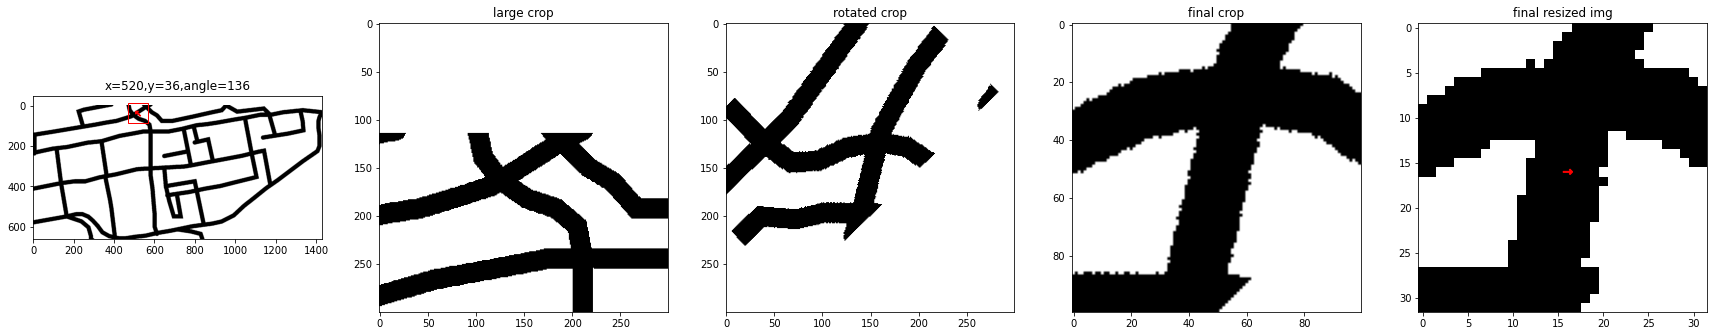

In [15]:
env = CarEnv("MASK1.png")
print(env.reset())
env.render()

# Set the Hyperparameters

In [0]:
start_timesteps = 2e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e4 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 5e5 # Total number of iterations/timesteps
expl_noise = 0.5 #0.1 # Exploration noise - STD value of exploration Gaussian noise
batch_size = 100 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.005 # Target network update rate
policy_noise = 1 # STD of Gaussian noise added to the actions for the exploration purposes
noise_clip = 2 # Maximum value of the Gaussian noise added to the actions (policy)
policy_freq = 2 # Number of iterations to wait before the policy network (Actor model) is updated

## Set seeds and get the necessary information on the states and actions in the chosen environment

In [0]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.state_dim
action_dim = env.action_dim[0]
max_action = env.max_action

## Create the policy network
* This sets up all the networks: Actor, Actor-Target, Critic1, Critic1-Target, Critic2, Critic2-Target

In [0]:
policy = T3D(state_dim, action_dim, max_action)

## Initialize the Experience Replay memory

In [0]:
replay_buffer = ReplayBuffer()

## Verify policy network before training

In [20]:
obs = env.reset()
action = policy.select_action(obs)
new_obs, reward, done,  = env.step(action)
print(obs[0].shape, obs[1].shape, new_obs[0].shape, new_obs[1].shape, action, reward, done)

torch.Size([1, 32, 32]) torch.Size([3]) torch.Size([1, 32, 32]) torch.Size([3]) [1.1403615] -0.5 False


## We make a function that evaluates the policy by calculating its average reward over 10 episodes

In [0]:
def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    done = False
    episode_timesteps = 0
    while not done:
      action = policy.select_action(obs)
      obs, reward, done = env.step(action)
      episode_timesteps += 1
      avg_reward += reward
      if episode_timesteps + 1 == env._max_episode_steps:
        done = True

  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

## Define a list where all the evaluation results over 10 episodes are stored

In [0]:
evaluations = []

## Initialize the variables

In [0]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()
#start_timesteps = 100

## Training process
* As part of training, we show following output:
  * Initial position of the car on the map with its cropped/rotated image. This is done to verify our image position and the cropping of the image
  * Total number of timesteps taken, Episode number, Length of current episod, Total reward accumulated during this episode and Time taken to finish this episode
```
Total Timesteps: 561 Episode Num: 1 Episode Len: 561 Reward: -449.7 Time Taken: 8.64677596092 secs
```
  * Distribution of rewards. This is not from replay memory, but from the actual steps taken during this run of episode. It shows how much and from where rewards were allocated. Like:
    ```
Rewards Distribution:  [('away', 64), ('sand', 2974), ('towards', 52)]
    ```
  * Amound of time taken by `policy.train` to finish 
```
Training took 24.9262328148 secs
```
  * Path is plotted on the map after completion of an episode to track network progress

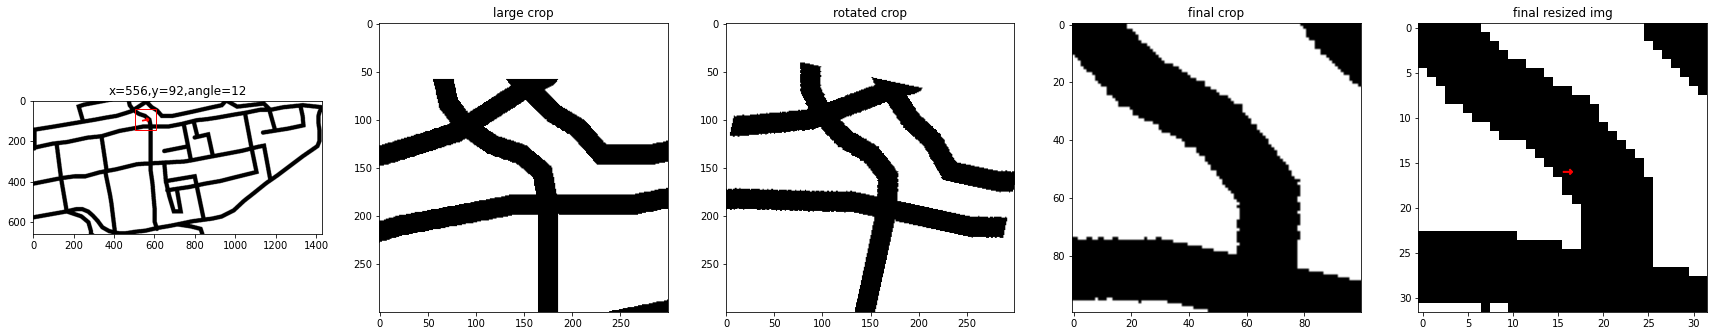

>>> tensor([ 0.1507, -0.5503,  0.5503]) [556, 92] 12 (-0.8009131049977078,)
>>> tensor([ 0.1748,  0.2772, -0.2772]) [579.9637943945161, 52.79423460966784] 164.51108107116113 (19.142837136828682,)
>>> tensor([ 0.1695,  0.4429, -0.4429]) [553.7227248553837, 25.12211596832739] 193.04619683035455 (-1.7594150712853107,)
>>> tensor([ 0.0910,  0.7312, -0.7312]) [444.70941706522734, 85.87917715188406] 232.54841075756002 (15.314399921751644,)
>>> tensor([ 0.0651,  0.3339, -0.3339]) [413.707174607155, 112.37039313298185] 157.63689833841408 (5.993278940938133,)
>>> tensor([ 0.0439,  0.5784, -0.5784]) [369.6349775917474, 118.25718874630414] 197.40639910133865 (0.42515627744720064,)
>>> tensor([ 0.0173,  0.8810, -0.8810]) [346.1079436257252, 153.08156222846443] 249.58251368204782 (-2.728602894993518,)
Total Timesteps: 629 Episode Num: 1 Episode Len: 629 Reward: -542.6000000000004 Time Taken: 10.590794086456299 secs
Rewards Distribution:  [('away', 11), ('goal', 1), ('sand', 554), ('towards', 64)]


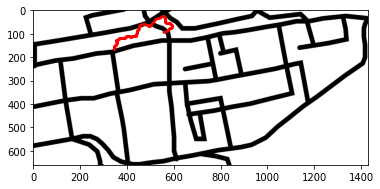

Training took 20.089428186416626 secs



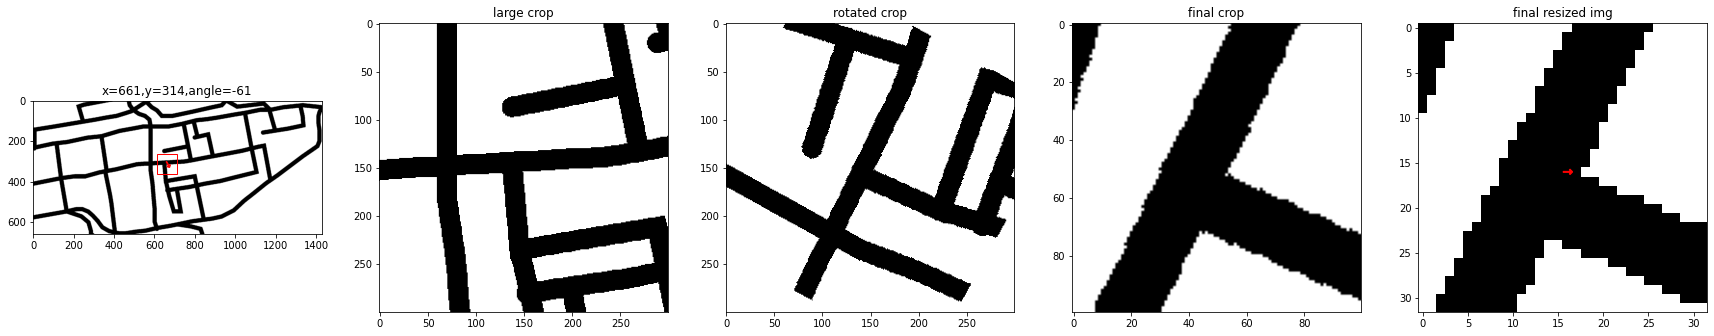

>>> tensor([ 0.2244, -0.9626,  0.9626]) [661, 314] -61 (-8.152495179457366,)
>>> tensor([ 0.2156, -0.7832,  0.7832]) [628.2866399372552, 348.69260929506555] -31.53205546570358 (6.141554987570448,)
>>> tensor([ 0.2430, -0.0602,  0.0602]) [681.9477555239645, 338.87957706372475] 102.07709997063282 (9.061630193348556,)
>>> tensor([ 0.2473, -0.7211,  0.7211]) [666.5163301183694, 382.09249399349477] 341.1955413462331 (-14.293603250903937,)
>>> tensor([ 0.2480,  0.7117, -0.7117]) [627.0652142753321, 436.88925855086313] 235.7338367204855 (-9.819175319796752,)
>>> tensor([ 0.2476,  0.4348, -0.4348]) [579.8350244942799, 481.14597363602496] 182.52308258909673 (-2.572639841215203,)
>>> tensor([ 0.2391,  0.4259, -0.4259]) [538.3889789633668, 494.6441735631144] 178.41735300261385 (-2.010790179689984,)
>>> tensor([ 0.2582, -0.6414,  0.6414]) [535.7474220328663, 531.3485418922392] 345.7451749919306 (3.17152160638301,)
>>> tensor([ 0.2784, -0.5808,  0.5808]) [576.7432813660503, 543.4361155759682] 358.7

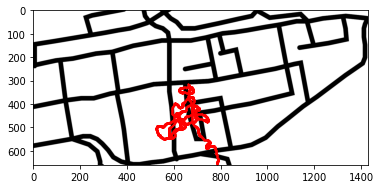

Training took 89.49491119384766 secs



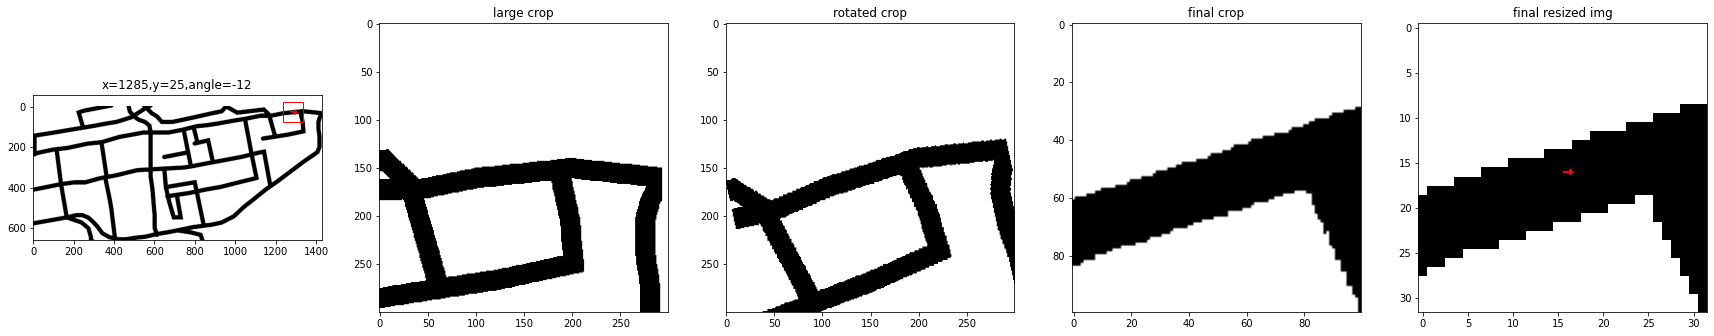

>>> tensor([ 0.6113, -0.9106,  0.9106]) [1285, 25] -12 (6.2738951797859634,)
Total Timesteps: 3488 Episode Num: 3 Episode Len: 41 Reward: -41.0 Time Taken: 90.86181926727295 secs
Rewards Distribution:  [('away', 18), ('sand', 22), ('wall', 1)]


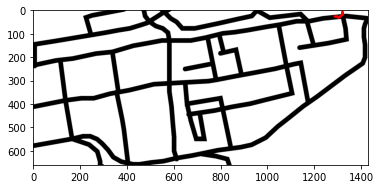

Training took 1.3199055194854736 secs



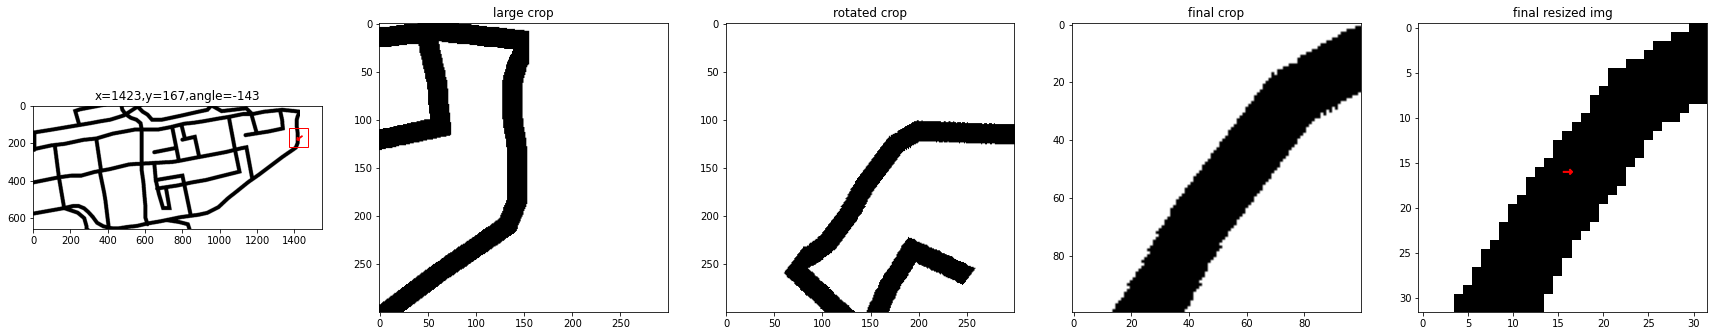

>>> tensor([ 0.6913,  0.3768, -0.3768]) [1423, 167] -143 (3.1311832934187187,)
>>> tensor([ 0.6559,  0.0219, -0.0219]) [1367.3443151266558, 190.36254614451892] -209.13599858208133 (5.78685996719647,)
>>> tensor([ 0.6295,  0.7642, -0.7642]) [1325.797723024954, 189.83537377729704] -76.5849037596543 (19.088110155973084,)
>>> tensor([ 0.6411,  0.9866, -0.9866]) [1342.5744225511744, 232.94182643736377] -37.77006409341712 (16.06452117089163,)
>>> tensor([ 0.6188,  0.6965, -0.6965]) [1299.0827228566018, 316.20379941372744] -94.25762533388307 (15.97904135983805,)
>>> tensor([ 0.6170, -0.1554,  0.1554]) [1295.4855694588953, 321.75717386967216] -247.88865415877166 (0.9140494424953474,)
>>> tensor([ 0.6233, -0.6903,  0.6903]) [1312.449016062834, 262.3044613073339] -341.53844433237816 (-19.215696120626248,)
>>> tensor([ 0.6643, -0.8743,  0.8743]) [1377.529869380747, 259.1236814341314] -372.7882994923712 (-11.265917898649057,)
>>> tensor([ 0.6930, -0.6866,  0.6866]) [1422.6066328030784, 261.2790057

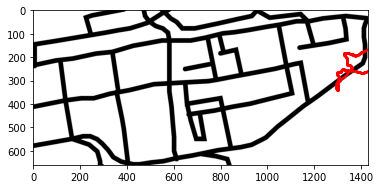

Training took 25.716134071350098 secs



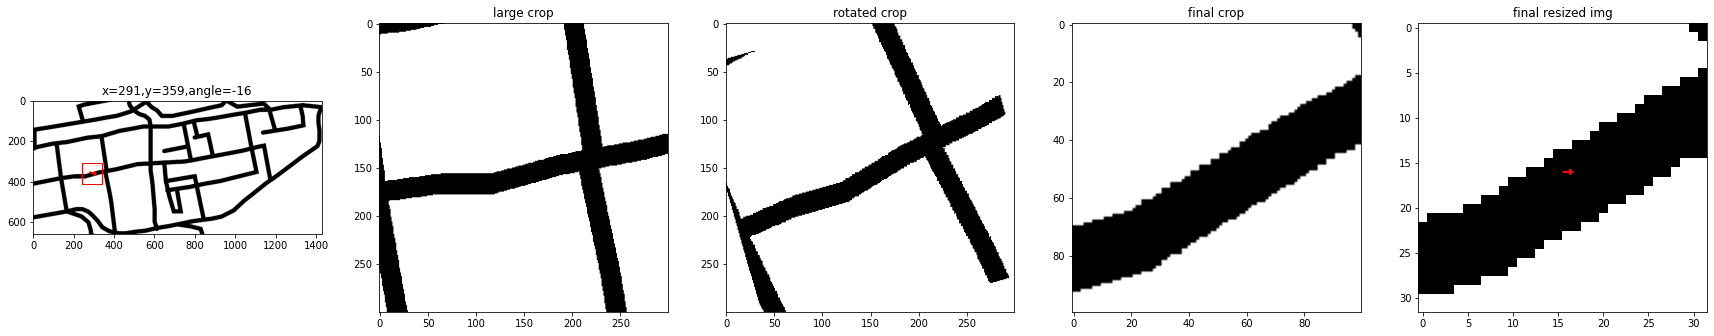

>>> tensor([ 0.1183, -0.5723,  0.5723]) [291, 359] -16 (-7.340920322362088,)
>>> tensor([ 0.1352, -0.6054,  0.6054]) [373.96594302518605, 387.1388537208648] -16.408599447298343 (2.5307517993897655,)
>>> tensor([ 0.1419, -0.3206,  0.3206]) [420.8682896189922, 384.1934413206515] 37.961522104272156 (17.70679403106594,)
>>> tensor([ 0.1401, -0.7617,  0.7617]) [449.8542258866787, 366.3064297433805] -39.38941775304483 (-0.5241233939346657,)
>>> tensor([ 0.1665,  0.9236, -0.9236]) [470.83959705772736, 402.10384026660415] -95.02148923984372 (-2.336921649243596,)
>>> tensor([ 0.1747,  0.6736, -0.6736]) [469.30092127415406, 418.0064930160167] -140.27162332008103 (-6.616976976854954,)
>>> tensor([ 0.2030, -0.8856,  0.8856]) [488.9020622835156, 457.9937916326981] -60.114381995756844 (9.859820301834223,)
>>> tensor([ 0.2187, -0.1907,  0.1907]) [533.7038895588668, 459.1547439183404] 67.5930777721772 (17.682521936368367,)
>>> tensor([ 0.2207,  0.7411, -0.7411]) [548.2720917721464, 452.2189501009761] 

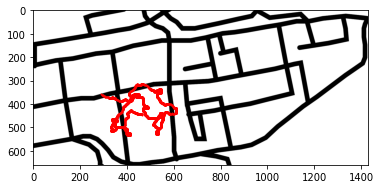

Training took 100.31736993789673 secs



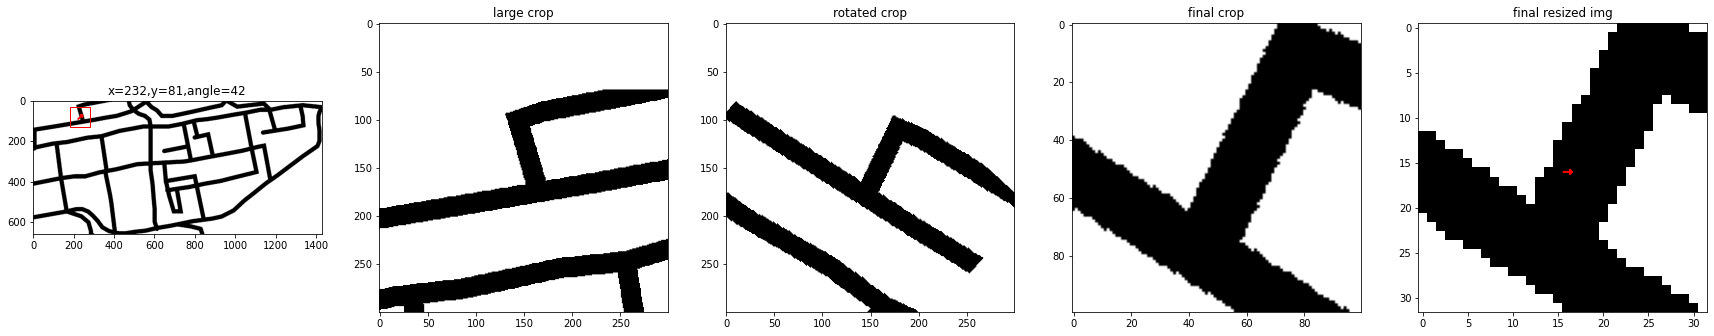

>>> tensor([ 0.0899, -0.2091,  0.2091]) [232, 81] 42 (-5.614415410466901,)
Total Timesteps: 7497 Episode Num: 6 Episode Len: 85 Reward: -75.7 Time Taken: 102.35245132446289 secs
Rewards Distribution:  [('away', 30), ('sand', 51), ('towards', 3), ('wall', 1)]


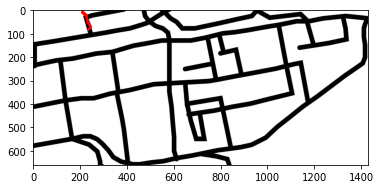

Training took 2.775172710418701 secs



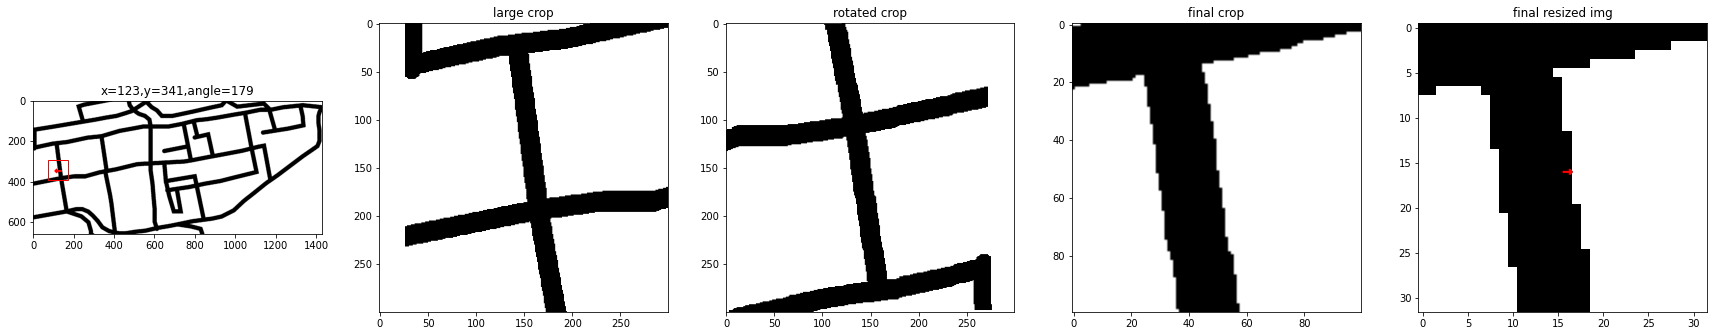

>>> tensor([ 0.1699,  0.5747, -0.5747]) [123, 341] 179 (9.027739063376742,)
>>> tensor([ 0.1581, -0.1038,  0.1038]) [126.39078945493853, 313.6257155737695] 56.622555946223585 (2.099811930559383,)
>>> tensor([ 0.1220, -0.2872,  0.2872]) [180.07308612468907, 291.5688800346273] 26.978491425703094 (16.427510626259306,)
>>> tensor([ 0.1209,  0.0476, -0.0476]) [161.61823684177202, 256.60556213037523] 85.3511055096737 (-7.792795774946164,)
>>> tensor([ 0.1022,  0.1028, -0.1028]) [177.3537457003678, 209.7322433492957] 95.67099502014226 (8.07406172540918,)
>>> tensor([ 0.1212,  0.2892, -0.2892]) [144.1994799616403, 175.28458298230092] 125.86232622038489 (-0.7319816003222002,)
>>> tensor([ 0.1324, -0.4275,  0.4275]) [127.73534141332324, 155.94793730949058] -4.953557309739725 (1.3539279848343426,)
>>> tensor([ 0.1485,  0.2078, -0.2078]) [113.53171163255216, 103.41676323686958] 106.67695193403205 (8.629919770809312,)
>>> tensor([ 0.1695,  0.1487, -0.1487]) [92.91856686497792, 65.72555080679794] 92

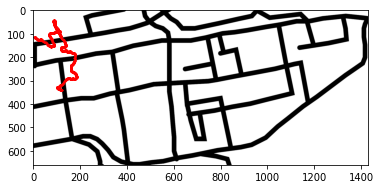

Training took 41.215734004974365 secs



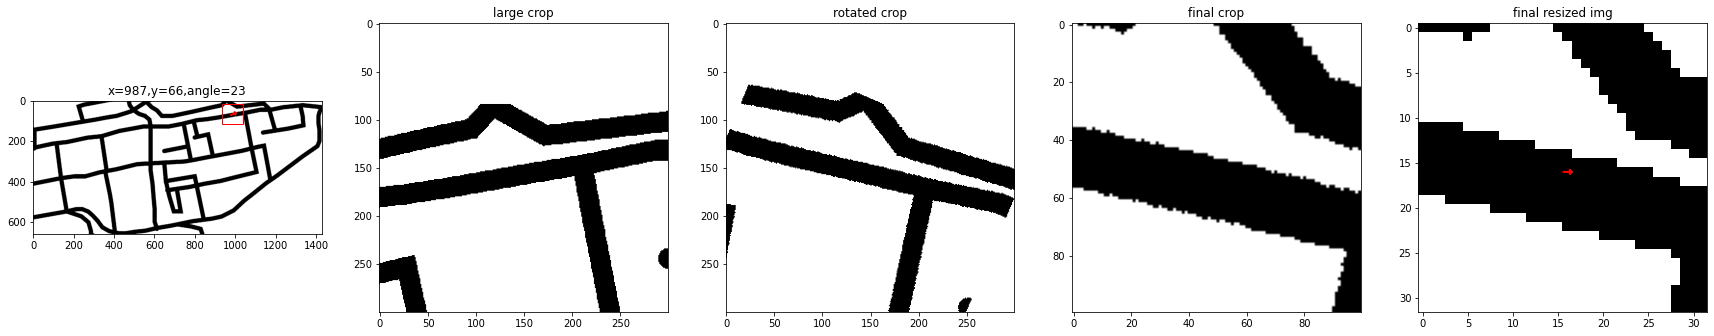

>>> tensor([ 0.4203, -0.6497,  0.6497]) [987, 66] 23 (-0.8693137810884295,)
>>> tensor([ 0.4507,  0.1246, -0.1246]) [1024.770267436649, 12.529764203036988] 166.79044899020397 (6.849658337231968,)
Total Timesteps: 8906 Episode Num: 8 Episode Len: 122 Reward: -120.5 Time Taken: 43.840572118759155 secs
Rewards Distribution:  [('away', 21), ('sand', 100), ('wall', 1)]


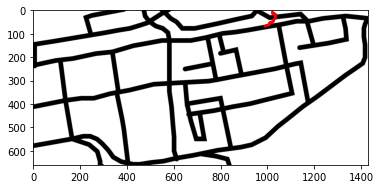

Training took 3.9541738033294678 secs



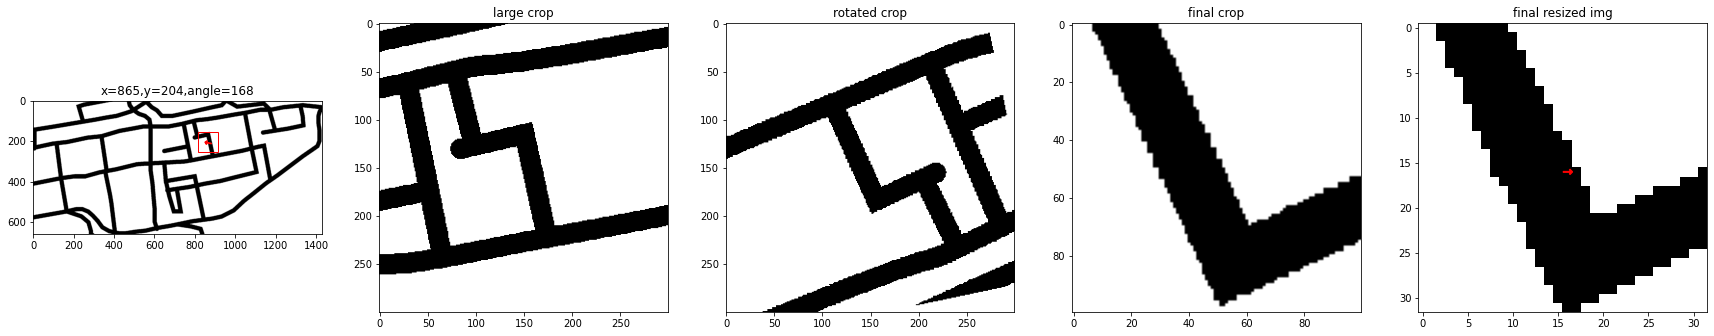

>>> tensor([ 0.3371,  0.2239, -0.2239]) [865, 204] 168 (4.435961105137739,)
>>> tensor([ 0.3141, -0.8627,  0.8627]) [828.0731538590582, 213.18659733621288] 330.05772159000844 (9.17519706427423,)
>>> tensor([ 0.3296,  0.2859, -0.2859]) [849.2956160443124, 246.49602397581324] 176.68129528130095 (-16.2676248266659,)
>>> tensor([ 0.3101, -0.0433,  0.0433]) [820.752950486671, 226.38396361127502] 116.65048847358611 (-13.616468578163584,)
>>> tensor([ 0.3220, -0.4047,  0.4047]) [841.5491108512307, 160.5337833239307] 55.40323948633046 (-18.32295279483471,)
>>> tensor([ 0.3487, -0.4674,  0.4674]) [882.107783208556, 135.24368540986782] 47.42416541096087 (5.302690476274918,)
>>> tensor([ 0.3344, -0.1824,  0.1824]) [856.4476780655588, 106.2992770068152] 98.72607613308615 (7.636474397447568,)
>>> tensor([ 0.3436, -0.5097,  0.5097]) [854.9540264822047, 29.293269884916345] 43.73985087026557 (9.04079450809553,)
>>> tensor([ 0.3180,  0.6671, -0.6671]) [824.4828269637044, 73.65659252395135] 251.45713426

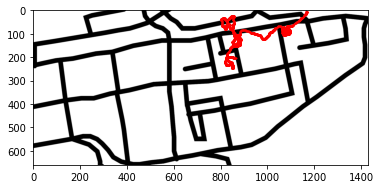

Training took 66.8212525844574 secs



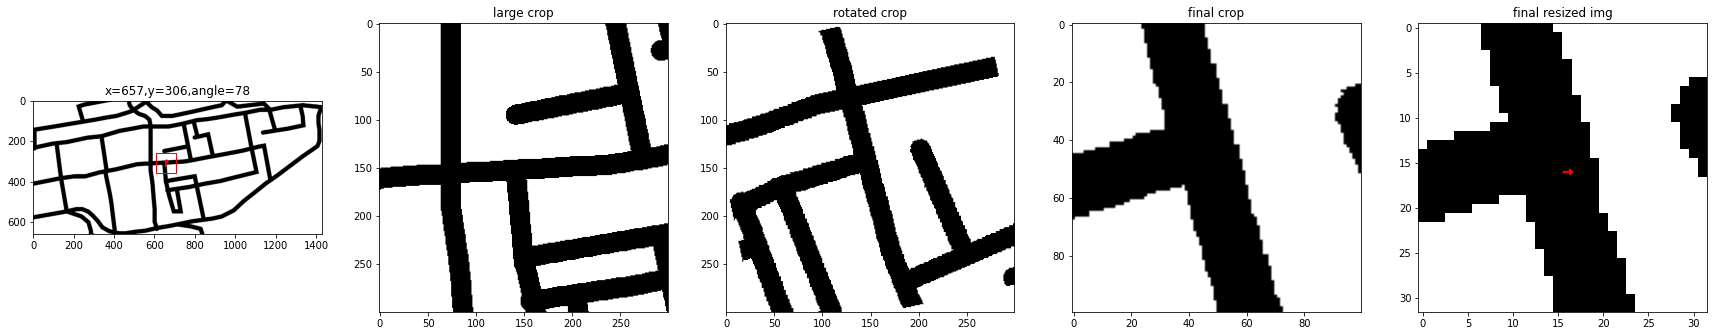

>>> tensor([ 0.2201, -0.1901,  0.1901]) [657, 306] 78 (7.179586456437729,)
>>> tensor([ 0.2117,  0.7498, -0.7498]) [652.4819091278051, 279.19247403089526] 247.61042365438453 (-4.953808735255123,)
>>> tensor([ 0.1620,  0.5254, -0.5254]) [546.4681632240105, 320.3496894914983] 199.33925527972752 (12.289743160900827,)
>>> tensor([ 0.1846,  0.6419, -0.6419]) [558.9938198225123, 362.9926686748368] 220.3805767224302 (16.65150599472598,)
>>> tensor([ 0.1736,  0.7584, -0.7584]) [518.9375546178811, 379.97556090695747] 238.55315579139616 (4.404599410850331,)
>>> tensor([ 0.2010, -0.6981,  0.6981]) [548.874853286533, 411.1195287504713] 337.80566617845165 (6.771078568223583,)
>>> tensor([ 0.2340, -0.6042,  0.6042]) [597.9803335218962, 435.8522960202262] 357.23519749958666 (-10.530350232402203,)
>>> tensor([ 0.2532, -0.7486,  0.7486]) [631.1444393106102, 444.69906669078864] 332.9763003963864 (5.011650532972347,)
>>> tensor([ 0.2668, -0.2245,  0.2245]) [676.997887895825, 421.6851255875711] 430.312645

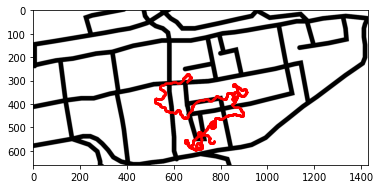

Training took 101.04899764060974 secs



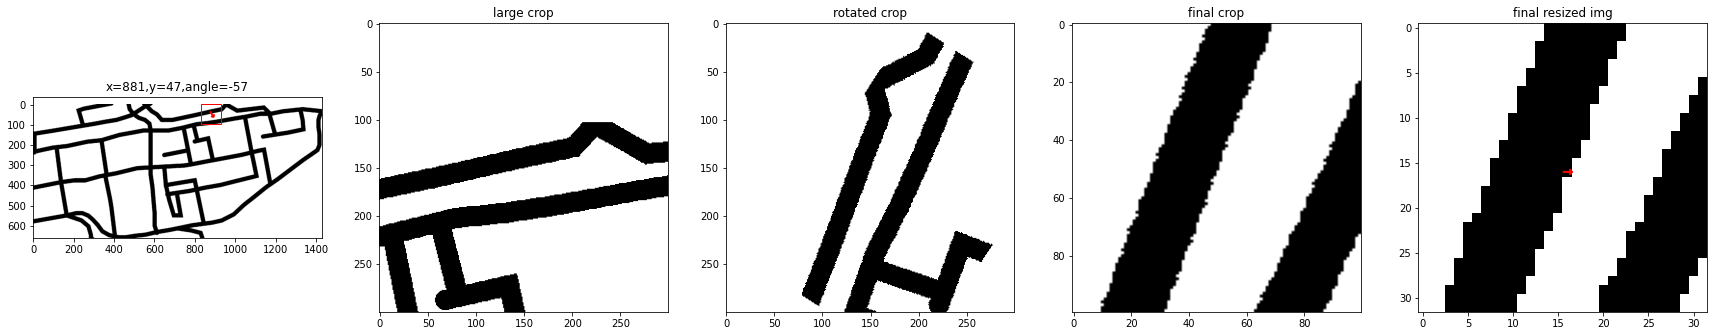

>>> tensor([ 0.3567,  0.9283, -0.9283]) [881, 47] -57 (-16.845294682247477,)
>>> tensor([ 0.3325,  0.8055, -0.8055]) [852.4392139384524, 99.81971467269703] -83.35497188342227 (-5.839196657255457,)
>>> tensor([ 0.3344, -0.7744,  0.7744]) [860.4844318112712, 147.43274834170182] -9.529961835569758 (15.628792175599202,)
>>> tensor([ 0.3319,  0.3076, -0.3076]) [856.8702629332657, 200.76895850714666] -177.23851955784693 (-0.3107625607339024,)
>>> tensor([ 0.3283,  0.0951, -0.0951]) [851.2047970734192, 153.70364716473063] -213.80325056451605 (-18.33915654789938,)
>>> tensor([ 0.3389, -0.6341,  0.6341]) [866.4015316646136, 131.37610527801215] -343.2364833137236 (-1.2702246085816853,)
>>> tensor([ 0.3384,  0.5373, -0.5373]) [863.6881452632299, 113.24785231324351] -131.68223371056797 (-10.466379545052774,)
>>> tensor([ 0.3107, -0.1439,  0.1439]) [820.6009455146523, 120.6061346109884] -257.0472108030121 (5.319846257587891,)
>>> tensor([ 0.3395, -0.6254,  0.6254]) [856.4628557833639, 61.2384389176

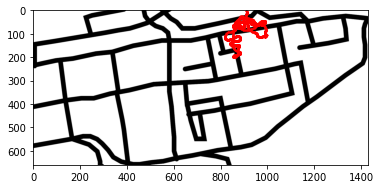

Training took 71.08298420906067 secs



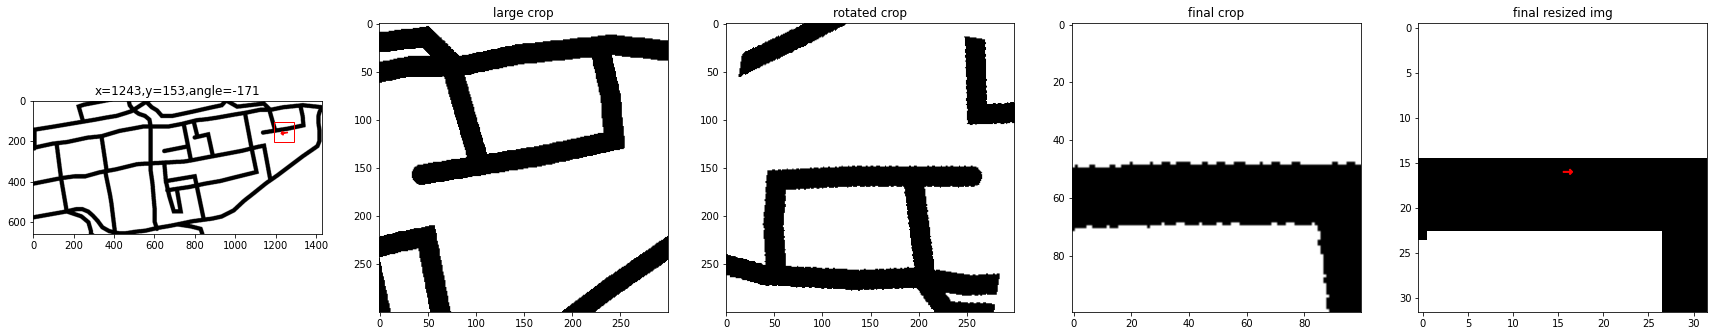

>>> tensor([ 0.5771,  0.2443, -0.2443]) [1243, 153] -171 (-13.631731279038455,)
>>> tensor([ 0.5779, -0.4763,  0.4763]) [1240.9485286829813, 97.26539951756169] -298.32719756068656 (9.980304159617734,)
>>> tensor([ 0.5772,  0.0076, -0.0076]) [1234.863337706989, 53.16120614251801] -209.3793465129288 (-17.491926136944343,)
>>> tensor([ 0.5945,  0.7935, -0.7935]) [1255.3135949009124, 9.0959108890906] -425.26106877055497 (15.882113562347541,)
>>> tensor([ 0.6040, -0.1030,  0.1030]) [1276.6550429358088, 47.75886130530017] -587.8970082889113 (-9.352437845845527,)
Total Timesteps: 16886 Episode Num: 12 Episode Len: 485 Reward: -456.29999999999984 Time Taken: 79.4001669883728 secs
Rewards Distribution:  [('away', 27), ('sand', 435), ('towards', 22), ('wall', 1)]


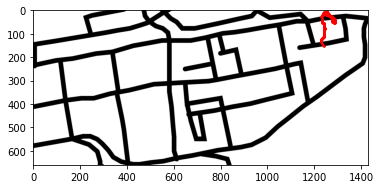

Training took 15.506815910339355 secs



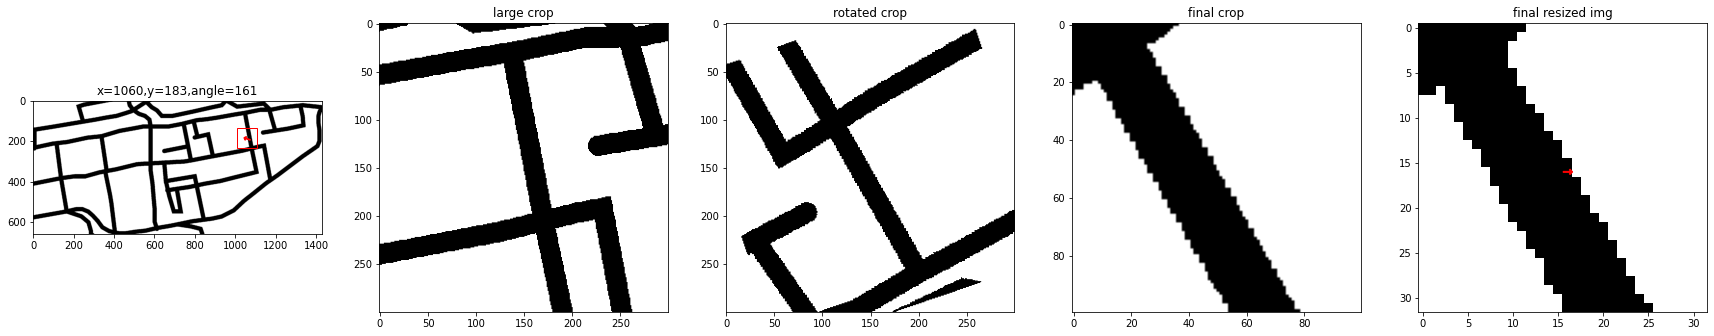

>>> tensor([ 0.4606,  0.1307, -0.1307]) [1060, 183] 161 (-2.8858481063037225,)
>>> tensor([ 0.4312,  0.5458, -0.5458]) [1013.3899344921612, 198.90480711020777] 233.14191926820948 (10.242829580026843,)
>>> tensor([ 0.4511, -0.9685,  0.9685]) [1043.306980220229, 227.7792478314819] 320.6114958864606 (11.57149164083254,)
>>> tensor([ 0.4806,  0.9353, -0.9353]) [1090.6921524277632, 211.51271553722748] 305.8059981771573 (15.53750298480302,)
>>> tensor([ 0.4965,  0.7949, -0.7949]) [1110.9324251653502, 271.0920877059586] 278.9428919264543 (12.32842932165076,)
>>> tensor([ 0.5137, -0.3851,  0.3851]) [1135.4776877211855, 292.25644084064106] 426.6273830443762 (8.180970575668756,)
>>> tensor([ 0.5440, -0.8291,  0.8291]) [1187.2902516684499, 260.9891107429821] 349.6846211249227 (-5.427420665125883,)
>>> tensor([ 0.5709, -0.6521,  0.6521]) [1229.3603733106586, 265.2902511456905] 382.7474208337512 (-17.189979808253376,)
>>> tensor([ 0.5985, -0.5061,  0.5061]) [1271.9591202634972, 275.69251315893337] 

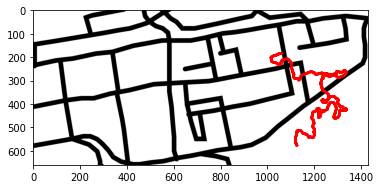

Training took 96.34310293197632 secs



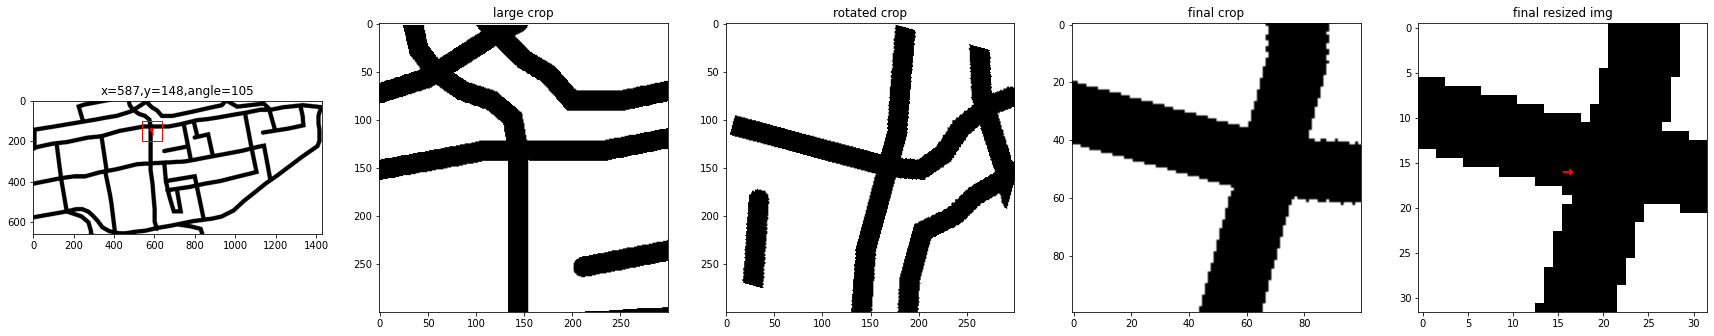

>>> tensor([ 0.1612, -0.0378,  0.0378]) [587, 148] 105 (-6.077499683181866,)


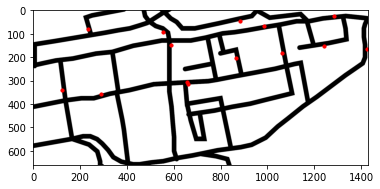

>>> tensor([ 0.1277,  0.8216, -0.8216]) [514.392505317069, 87.19867538732748] 255.37992132958428 [-4.04841894]
>>> tensor([ 0.1163,  0.9808, -0.9808]) [516.280702167189, 153.0936249984812] 282.4821350066309 [2.82571942]
>>> tensor([ 0.1194, -0.2688,  0.2688]) [522.6962024767446, 187.84722202565544] 777.264451076434 [18.82545738]
>>> tensor([ 0.1172,  0.9040, -0.9040]) [518.2288614118803, 198.71064212386207] 2067.7872432449058 [-5.19860629]
>>> tensor([ 0.1254,  0.9271, -0.9271]) [519.3035045260699, 248.66306481172398] 2071.0348234152607 [-0.058862]
>>> tensor([ 0.1400,  0.9094, -0.9094]) [519.4704529666402, 298.46060621370594] 2066.987095260718 [1.37339464]
>>> tensor([ 0.1678, -0.9011,  0.9011]) [522.1169328500239, 364.3976534373046] 2100.2623180814385 [8.62094456]
>>> tensor([ 0.1743,  0.9002, -0.9002]) [521.1418297440135, 379.56171522223633] 3144.233407107703 [1.67645325]
>>> tensor([ 0.1977,  0.9067, -0.9067]) [518.2207211091961, 429.43845154245565] 3144.5749155376834 [0.09058822]


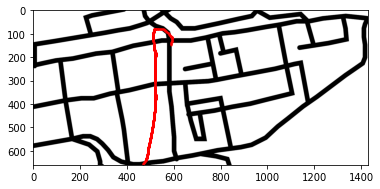

Training took 42.58748435974121 secs



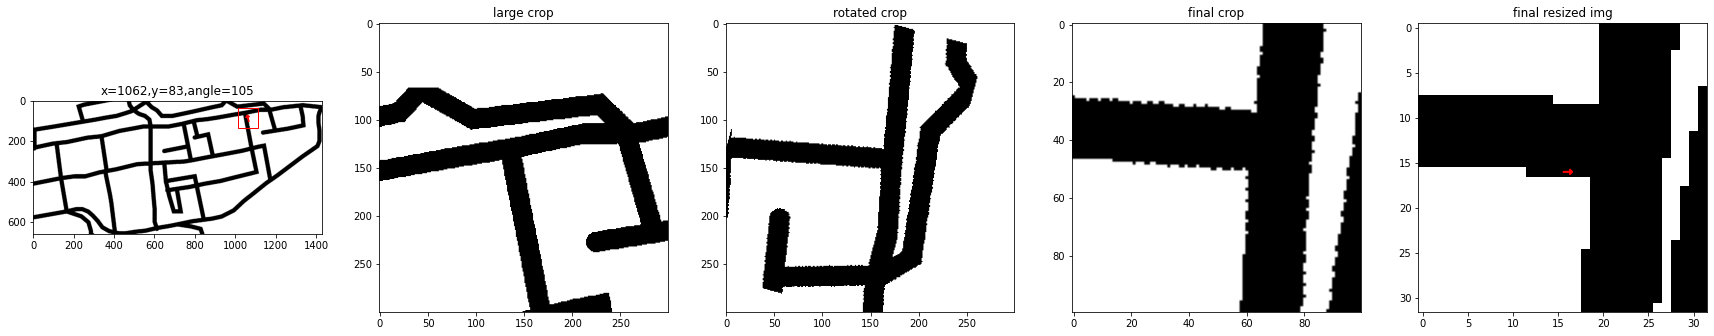

>>> tensor([ 0.4658, -0.2064,  0.2064]) [1062, 83] 105 [9.72501075]
>>> tensor([ 0.3934,  0.4306, -0.4306]) [946.0773701044326, 78.21173269676562] 214.9945791459866 [-2.78102809]
>>> tensor([ 0.2676,  0.4605, -0.4605]) [751.3592125860295, 114.4331932650284] 207.8039654480554 [7.61786404]
>>> tensor([ 0.2293,  0.3036, -0.3036]) [694.1259644471763, 142.02370112300474] 174.56809444571482 [-1.12267435]
>>> tensor([ 0.1968,  0.3603, -0.3603]) [642.9701706181957, 144.52527753174738] 181.02277825685653 [-0.37337821]
>>> tensor([ 0.1649,  0.3175, -0.3175]) [591.9082917181564, 140.52527750000658] 169.57670255808372 [0.42526292]
>>> tensor([ 0.0403,  0.5771, -0.5771]) [396.8154232660167, 163.93916764907925] 199.3372433542379 [-5.81186647]
Total Timesteps: 21884 Episode Num: 15 Episode Len: 623 Reward: -295.799999999997 Time Taken: 54.433284282684326 secs
Rewards Distribution:  [('away', 1), ('goal', 1), ('sand', 334), ('towards', 287)]


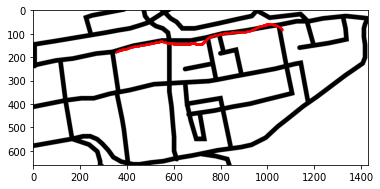

Training took 19.832143783569336 secs



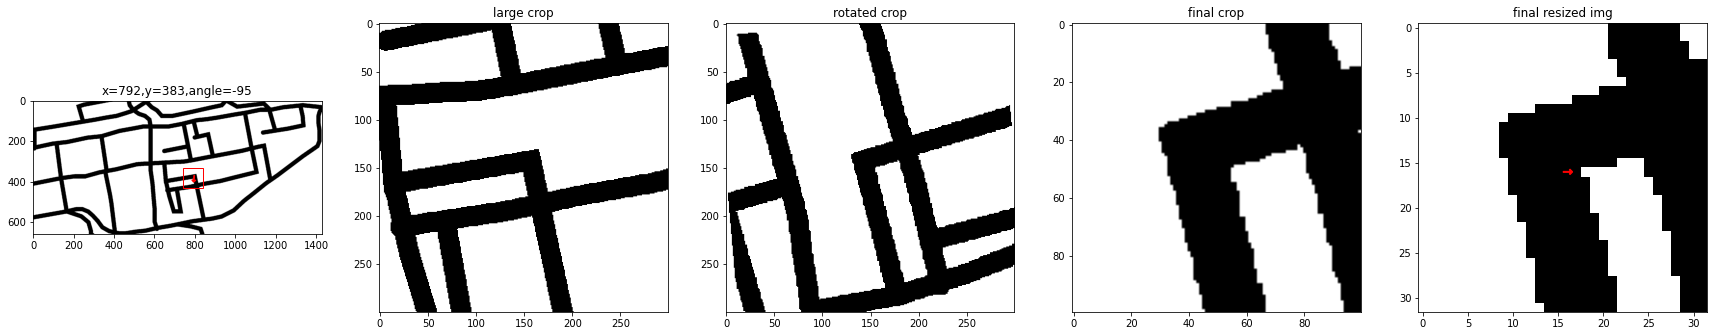

>>> tensor([ 0.3182,  0.8175, -0.8175]) [792, 383] -95 [-4.52285834]
>>> tensor([ 0.3081,  0.5468, -0.5468]) [738.1360556553964, 447.6311460627295] -148.13488150887326 [1.45389431]
>>> tensor([ 0.3043,  0.6198, -0.6198]) [692.3878815823302, 496.97842844085005] -138.37947475512124 [-4.83244338]
>>> tensor([ 0.3062,  0.5958, -0.5958]) [647.0181947000317, 545.3900170388746] -145.85566255602694 [3.75739752]
>>> tensor([ 0.3064,  0.6780, -0.6780]) [589.058212914597, 587.9867799827422] -134.61009524381447 [0.08776792]
>>> tensor([ 0.3102,  0.6523, -0.6523]) [548.6174597132721, 617.1073224642789] -141.59403242525715 [2.88856925]
Total Timesteps: 22457 Episode Num: 16 Episode Len: 573 Reward: -514.0000000000002 Time Taken: 30.960190296173096 secs
Rewards Distribution:  [('away', 37), ('sand', 490), ('towards', 45), ('wall', 1)]


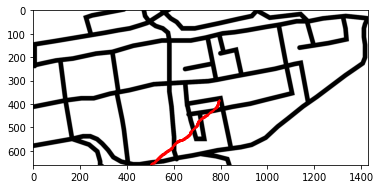

Training took 18.219876289367676 secs



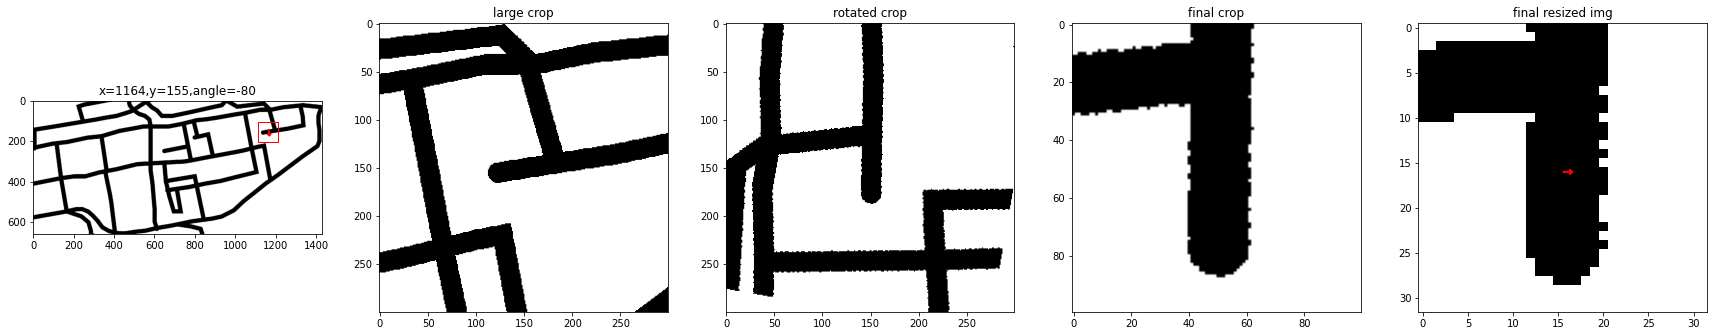

>>> tensor([ 0.5269,  0.7641, -0.7641]) [1164, 155] -80 [2.77163434]
>>> tensor([ 0.5269,  0.6617, -0.6617]) [1163.6189571605346, 212.87948101021195] -100.87883269910088 [-2.45585246]
>>> tensor([ 0.5191,  0.6988, -0.6988]) [1141.8945635609857, 306.23307788250537] -98.54247114428352 [5.89242758]
>>> tensor([ 0.5255,  0.8815, -0.8815]) [1142.8313642524922, 355.48983214844145] -67.35854671369641 [1.97074165]
>>> tensor([ 0.5351,  0.6393, -0.6393]) [1143.8602907624543, 412.79867243002457] -112.80846673094554 [3.5308031]
>>> tensor([ 0.4837,  0.5739, -0.5739]) [999.6280681302887, 549.3718818253394] -133.8955836977492 [1.07548003]
>>> tensor([ 0.4845,  0.8719, -0.8719]) [972.5072705400825, 596.5820599554214] -82.48009997637982 [-1.72633281]
>>> tensor([ 0.4921,  0.6627, -0.6627]) [955.0105794351135, 642.3345314886153] -121.84413060837896 [0.04936547]
Total Timesteps: 23185 Episode Num: 17 Episode Len: 728 Reward: -584.7999999999977 Time Taken: 31.939334869384766 secs
Rewards Distribution:  

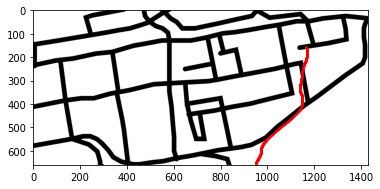

Training took 23.230976343154907 secs



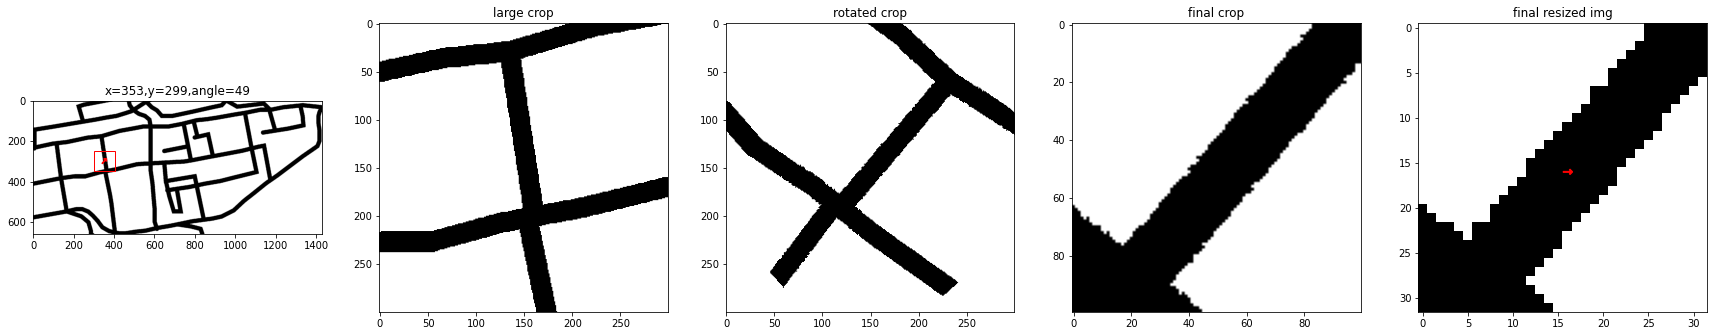

>>> tensor([ 0.0777, -0.2351,  0.2351]) [353, 299] 49 [19.35868807]
>>> tensor([ 0.0730,  0.4609, -0.4609]) [298.4266769907304, 286.8717420109877] 170.2439441828026 [-5.09516572]
>>> tensor([ 0.0797,  0.4488, -0.4488]) [251.2072019591349, 271.2899900844079] 164.44399771556982 [-0.20852372]
>>> tensor([ 0.1014,  0.5347, -0.5347]) [201.7543130153975, 265.9191331119472] 176.136058356353 [5.365432]
>>> tensor([ 0.1269,  0.4338, -0.4338]) [152.80779584263752, 259.8504222410155] 154.2782254371558 [1.22498818]
>>> tensor([ 0.1583,  0.4259, -0.4259]) [91.83445193211456, 232.12956649837722] 147.86664605794158 [-0.75467883]
>>> tensor([ 0.2068,  0.5250, -0.5250]) [10.368143016106051, 201.5454536679197] 159.08777783249937 [5.6877149]
Total Timesteps: 23788 Episode Num: 18 Episode Len: 603 Reward: -583.2 Time Taken: 34.648911476135254 secs
Rewards Distribution:  [('away', 40), ('sand', 554), ('towards', 8), ('wall', 1)]


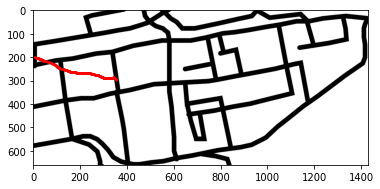

Training took 19.17831325531006 secs



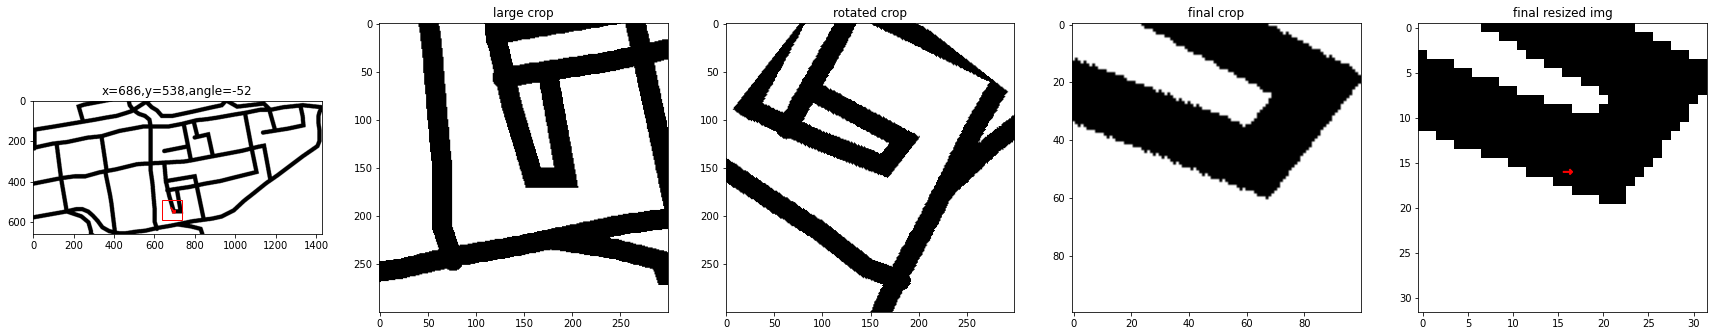

>>> tensor([ 0.3194, -0.8944,  0.8944]) [686, 538] -52 [13.79711592]
>>> tensor([ 0.2964,  0.4360, -0.4360]) [638.4391606310691, 532.2733099765209] 185.1275836712445 [-4.73321597]
>>> tensor([ 0.2739,  0.5143, -0.5143]) [572.5118173996724, 537.8129426887392] 195.69033631472706 [-1.47714948]
>>> tensor([ 0.2526,  0.3667, -0.3667]) [524.8673725563094, 527.3986247292385] 166.65347291074568 [0.44310602]
>>> tensor([ 0.2339,  0.3952, -0.3952]) [475.7390803497728, 518.1277180313833] 169.13891645379124 [-0.56566158]
>>> tensor([ 0.2182,  0.5092, -0.5092]) [427.33231425769293, 508.8347794187624] 186.97393761226434 [-7.10575598]
>>> tensor([ 0.2153,  0.5776, -0.5776]) [361.5306478607431, 515.8561295551707] 195.4953363532765 [-4.82815157]
>>> tensor([ 0.2134,  0.4615, -0.4615]) [311.99497339206727, 513.0568267947859] 171.73941794346936 [-0.01752168]
>>> tensor([ 0.2241,  0.5746, -0.5746]) [264.08936671048815, 523.6099319009871] 189.3913614286377 [-0.36926828]
>>> tensor([ 0.2300,  0.5334, -0.533

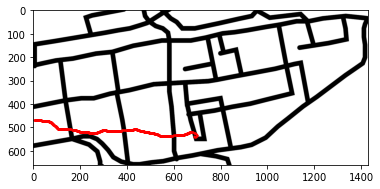

Training took 41.761319398880005 secs



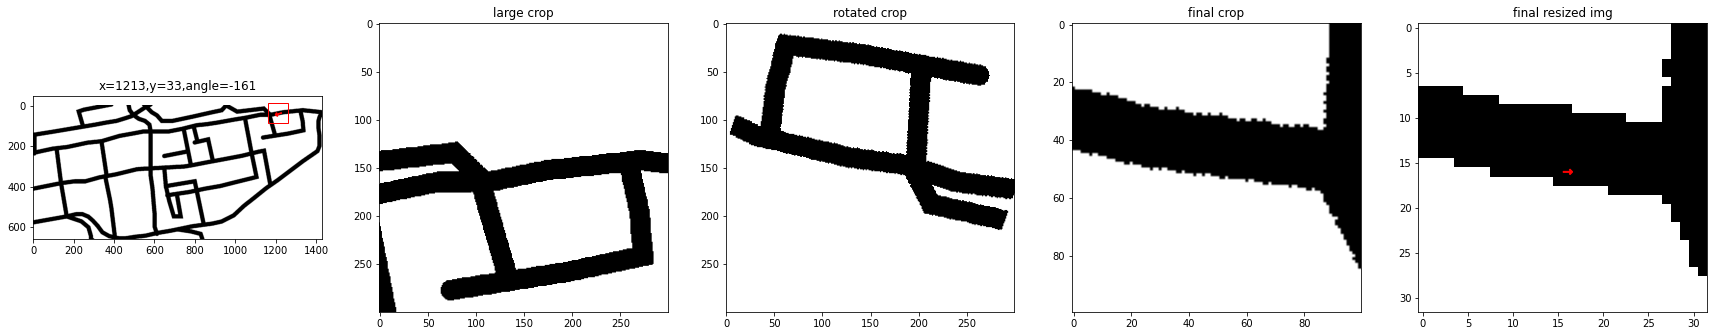

>>> tensor([ 0.5654,  0.2744, -0.2744]) [1213, 33] -161 [6.28921105]
>>> tensor([ 0.5314,  0.5988, -0.5988]) [1170.6735870471966, 143.4593894631891] -109.02455927357143 [3.50004961]
>>> tensor([ 0.5274,  0.6677, -0.6677]) [1164.608610629165, 208.98377239740054] -99.61286607102853 [-12.25808727]
>>> tensor([ 0.5119,  0.6827, -0.6827]) [1134.2139933039903, 280.5525717197809] -100.77707094273653 [3.2771792]
>>> tensor([ 0.5133,  0.7041, -0.7041]) [1128.5292646031116, 330.03033885917887] -98.91437052279299 [2.10503902]
>>> tensor([ 0.5146,  0.5540, -0.5540]) [1119.8440359800918, 378.2690895755275] -127.90482509421675 [-0.761837]
>>> tensor([ 0.5067,  0.6255, -0.6255]) [1094.5760491371148, 421.01334937918824] -117.33457739111182 [-0.4601272]
>>> tensor([ 0.4965,  0.5449, -0.5449]) [1049.3517745758234, 494.8803662994453] -135.73981508638207 [8.35816806]
>>> tensor([ 0.4671,  0.5518, -0.5518]) [948.7003933956577, 582.8004359330669] -140.71276810255608 [-1.96194323]
>>> tensor([ 0.4726,  0.656

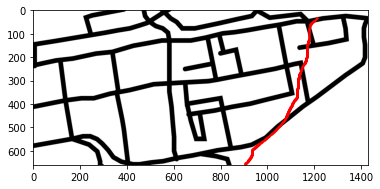

Training took 30.875070333480835 secs



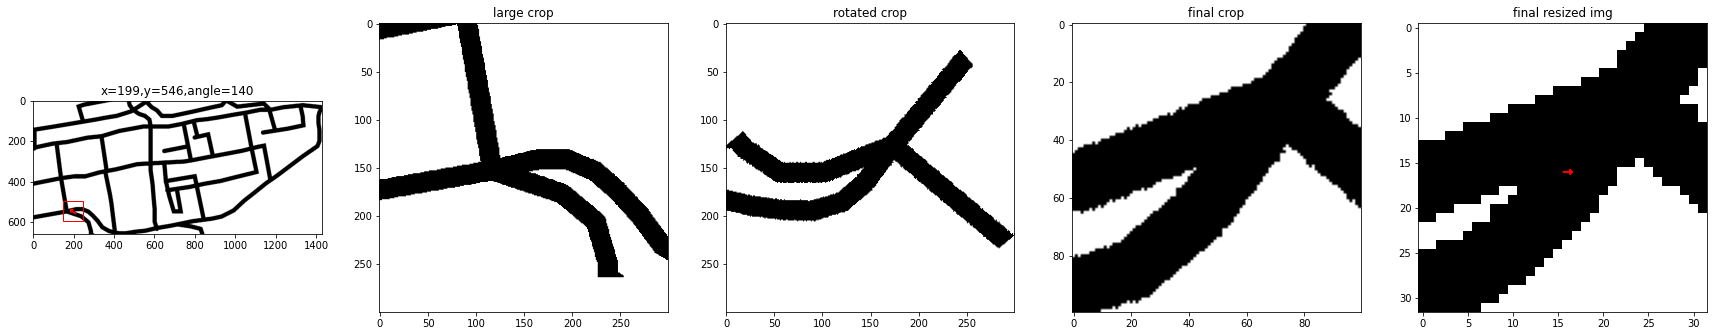

>>> tensor([ 0.2493,  0.3196, -0.3196]) [199, 546] 140 [17.89491731]
>>> tensor([ 0.2935,  0.8649, -0.8649]) [128.16562835745435, 591.0437303879454] 234.7675523421384 [7.02818306]
>>> tensor([ 0.3179,  0.6859, -0.6859]) [86.77888020631914, 612.5006621362613] 200.68113587623282 [10.45201168]
>>> tensor([ 0.3409,  0.7246, -0.7246]) [39.1990965526431, 625.5876665841473] 205.468111756559 [-2.32428389]
Total Timesteps: 26450 Episode Num: 21 Episode Len: 372 Reward: -367.4 Time Taken: 38.31689786911011 secs
Rewards Distribution:  [('away', 25), ('sand', 345), ('towards', 1), ('wall', 1)]


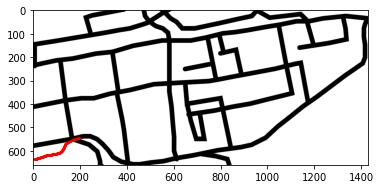

Training took 11.897433042526245 secs



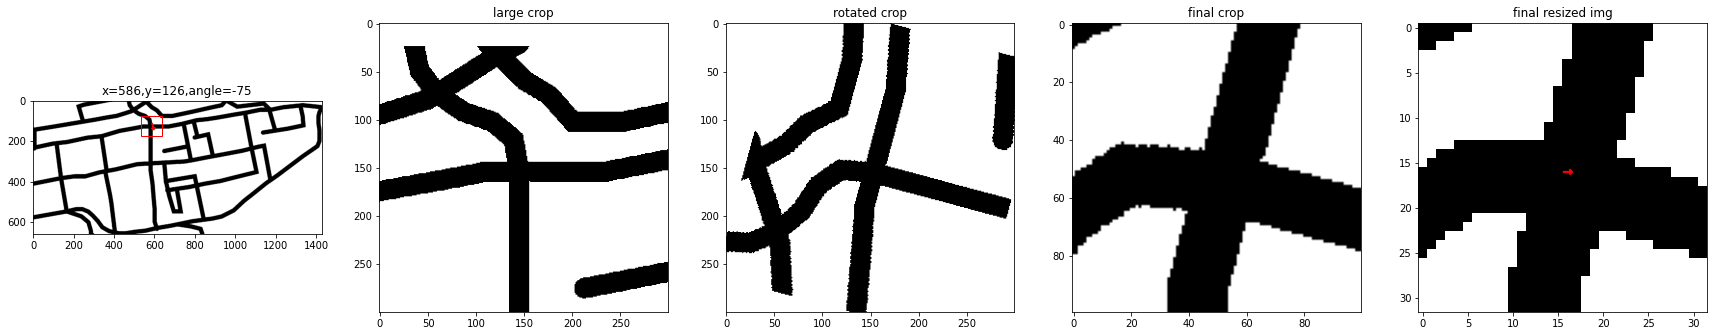

>>> tensor([ 0.1629,  0.9587, -0.9587]) [586, 126] -75 [-3.9343338]
>>> tensor([ 0.1648,  0.9586, -0.9586]) [592.6566501499275, 207.3528808428623] 1003.0491819402334 [7.18636538]
>>> tensor([ 0.1691,  0.9256, -0.9256]) [594.4276523538907, 237.75796867165775] 1716.4329243787547 [6.90273981]
>>> tensor([ 0.1720, -0.8503,  0.8503]) [596.4610389268893, 248.31325777754475] 3196.6442151029796 [18.67409034]
>>> tensor([ 0.1721,  0.6732, -0.6732]) [596.215529112894, 249.95966785642403] 4910.820276393431 [18.26987993]
>>> tensor([ 0.1746,  0.0688, -0.0688]) [599.0803958669762, 253.91062965518188] 6602.124134128244 [19.20783356]
>>> tensor([ 0.1748,  0.9827, -0.9827]) [597.1454213585268, 261.7090027264872] 8206.29972858626 [-3.56224512]
>>> tensor([ 0.1914,  0.9412, -0.9412]) [610.3085107675131, 300.3508784475877] 8558.803494083715 [9.4170223]
>>> tensor([ 0.2000,  0.8058, -0.8058]) [626.6533267041441, 296.64770342277984] 10335.583349599292 [16.00249819]
>>> tensor([ 0.2095,  0.5521, -0.5521]) [

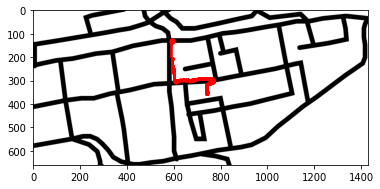

Training took 104.76248979568481 secs



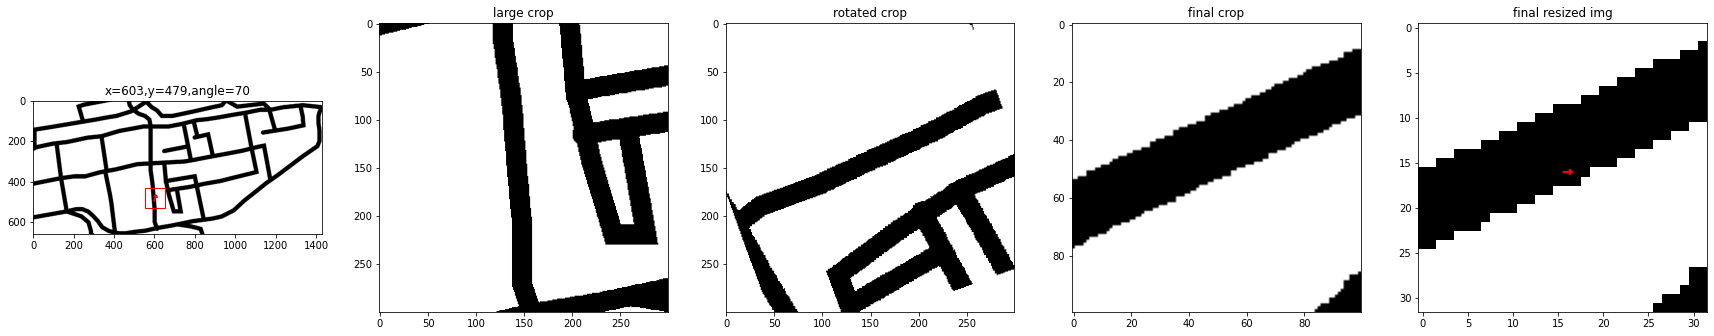

>>> tensor([ 0.2560, -0.1977,  0.1977]) [603, 479] 70 [17.52699544]
>>> tensor([ 0.2512, -0.3999,  0.3999]) [591.9199422319981, 478.5215978322172] 1832.9850746636623 [17.45084125]
>>> tensor([ 0.2360, -0.6109,  0.6109]) [581.8321299310616, 455.5271266410076] 3594.796824421938 [18.81132684]
>>> tensor([ 0.2351, -0.7701,  0.7701]) [579.7878540802923, 455.59621600343525] 5366.008589966289 [19.1410972]
>>> tensor([ 0.2343, -0.8792,  0.8792]) [578.1419198864861, 455.36224413842933] 7146.286783481297 [19.78418909]
>>> tensor([ 0.2334, -0.9952,  0.9952]) [576.4816440217611, 454.79469111516477] 8925.310545993574 [19.61801862]
>>> tensor([ 0.2326,  0.9174, -0.9174]) [575.1230025254408, 454.31711577919054] 10709.523409344254 [16.20898954]
>>> tensor([ 0.2317,  0.8051, -0.8051]) [573.9020039717063, 453.4884446066105] 12489.246530745771 [16.3885433]
>>> tensor([ 0.2310,  0.7185, -0.7185]) [572.863941059989, 452.98381578757375] 14273.60974018107 [17.35613569]
>>> tensor([ 0.2302,  0.6239, -0.6239])

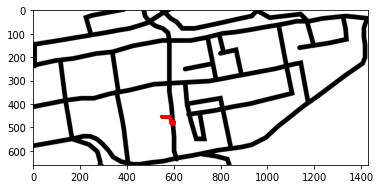

Training took 99.46781992912292 secs



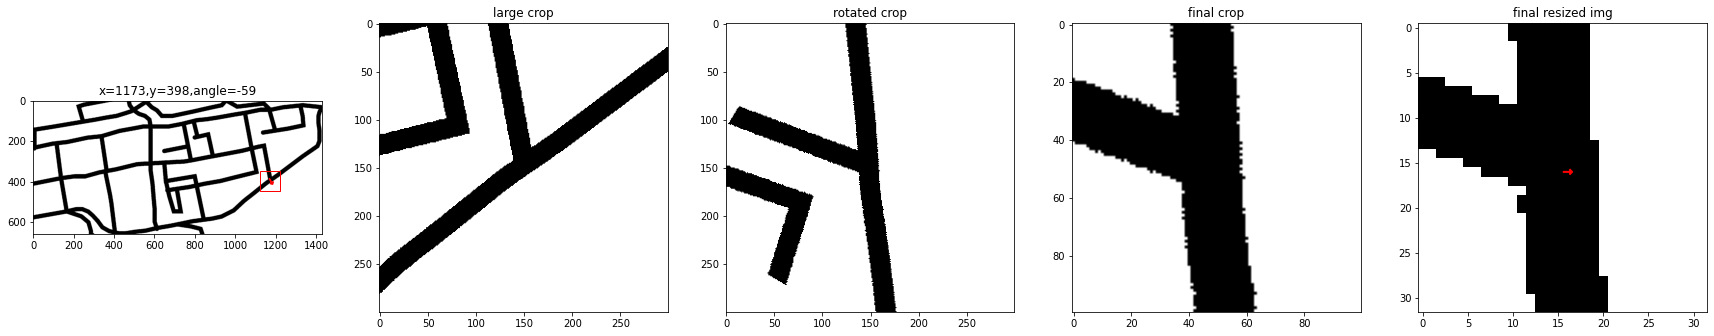

>>> tensor([ 0.5504,  0.9300, -0.9300]) [1173, 398] -59 [15.52572676]
>>> tensor([ 0.5451,  0.5107, -0.5107]) [1164.8996503532512, 395.6410537546225] 1665.3213351978402 [16.93162228]
>>> tensor([ 0.5467,  0.0576, -0.0576]) [1166.669949578686, 399.0685683513947] 3383.7127147684796 [17.40782587]
>>> tensor([ 0.5469, -0.3835,  0.3835]) [1162.9860809479524, 413.71721796397634] 5103.710957691465 [18.8107099]
>>> tensor([ 0.5361, -0.8485,  0.8485]) [1138.2612660884008, 436.2672738834814] 6818.4447381269465 [20.]
>>> tensor([ 0.5295,  0.7150, -0.7150]) [1123.458265507169, 448.1921898504343] 8538.983356996936 [13.73455772]
>>> tensor([ 0.5293,  0.2906, -0.2906]) [1123.1806655246205, 447.91946422696446] 10262.584517991845 [17.14808349]
>>> tensor([ 0.5298, -0.1280,  0.1280]) [1123.2407410260128, 450.0817516490987] 11987.177911346747 [16.41131432]
>>> tensor([ 0.5292, -0.5323,  0.5323]) [1121.141227703021, 453.3768703370213] 13714.237360845329 [19.25264201]
>>> tensor([ 0.5262,  0.9901, -0.9901]

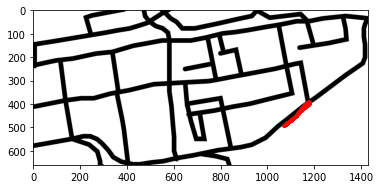

Training took 111.94519853591919 secs



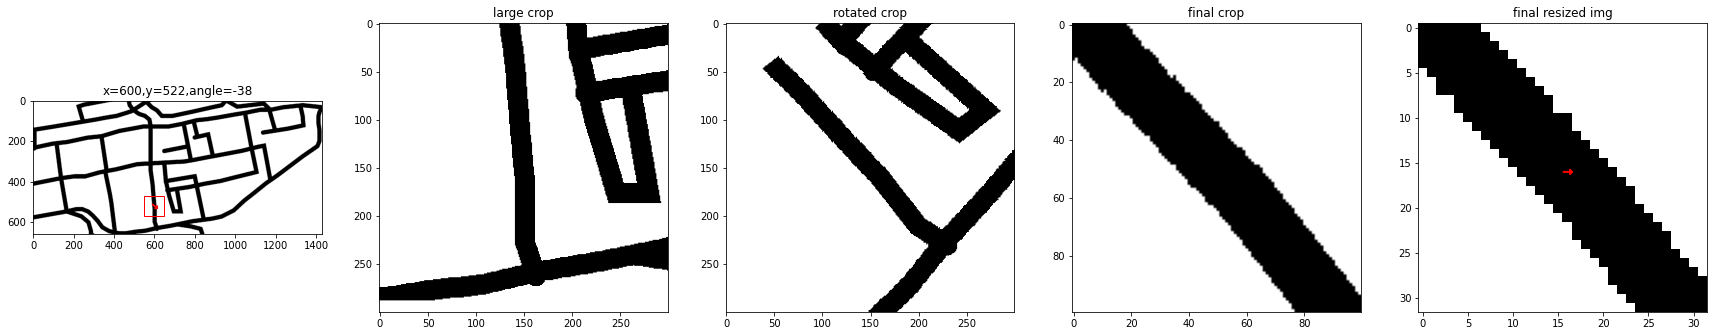

>>> tensor([ 0.2759, -0.7933,  0.7933]) [600, 522] -38 [4.10865372]
>>> tensor([ 0.2965, -0.6147,  0.6147]) [614.9338944207122, 551.3670799356208] 1434.5123141632848 [18.87696685]
>>> tensor([ 0.2966,  0.9752, -0.9752]) [613.7501416653814, 552.580339205078] 3160.6146440783527 [18.04708991]
>>> tensor([ 0.2972,  0.6059, -0.6059]) [614.8131136426109, 552.7852393603064] 4894.196518846147 [18.01550073]
>>> tensor([ 0.2988,  0.2359, -0.2359]) [616.9827096389935, 554.3793207315563] 6627.687799256456 [16.77081419]
>>> tensor([ 0.3022, -0.3647,  0.3647]) [618.7175693264794, 559.6999791251801] 8319.589820612731 [19.31526226]
>>> tensor([ 0.3031, -0.6730,  0.6730]) [618.5661953494837, 561.6388898491372] 10064.05490016831 [17.53549784]
>>> tensor([ 0.3038,  0.5957, -0.5957]) [620.8660306496796, 561.3203674018156] 11732.55006308716 [17.88801324]
>>> tensor([ 0.3099,  0.7808, -0.7808]) [626.9606388663443, 568.7339510696116] 13206.068400469368 [17.93101651]
>>> tensor([ 0.3173,  0.3782, -0.3782]) [6

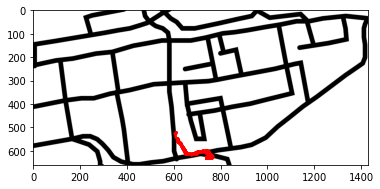

Training took 108.89630031585693 secs



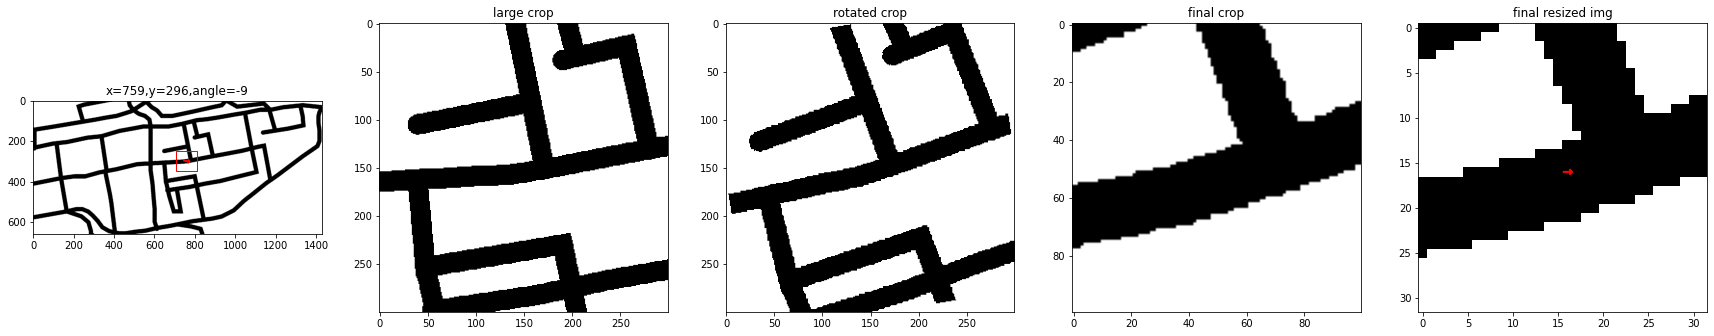

>>> tensor([ 0.2796, -0.7088,  0.7088]) [759, 296] -9 [20.]
>>> tensor([ 0.2813,  0.2311, -0.2311]) [765.7017152367965, 280.5567028791419] 1961.0635589429203 [19.29487527]
>>> tensor([ 0.2812, -0.8315,  0.8315]) [764.7696198382589, 283.57407034055507] 3929.632425663923 [19.55562208]
>>> tensor([ 0.2814,  0.1504, -0.1504]) [765.8567523156408, 280.93095551152936] 5906.526684126147 [19.78191867]
>>> tensor([ 0.2810, -0.8912,  0.8912]) [764.4117475981387, 283.6723383793815] 7878.863460620886 [20.]
>>> tensor([ 0.2816,  0.0672, -0.0672]) [766.0306513294471, 281.3288018145574] 9851.550688803623 [20.]
>>> tensor([ 0.2807, -0.9836,  0.9836]) [764.0207377920635, 283.5344499669057] 11822.213835411292 [19.20789069]
>>> tensor([ 0.2818, -0.0630,  0.0630]) [766.2106190466119, 281.9957545843221] 13788.103262427316 [19.26778733]
>>> tensor([ 0.2803,  0.8765, -0.8765]) [763.4796026559724, 283.3365542213069] 15757.012412148022 [19.63623243]
>>> tensor([ 0.2819, -0.2054,  0.2054]) [766.1706944018784, 28

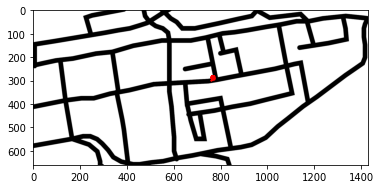

Training took 98.12348341941833 secs



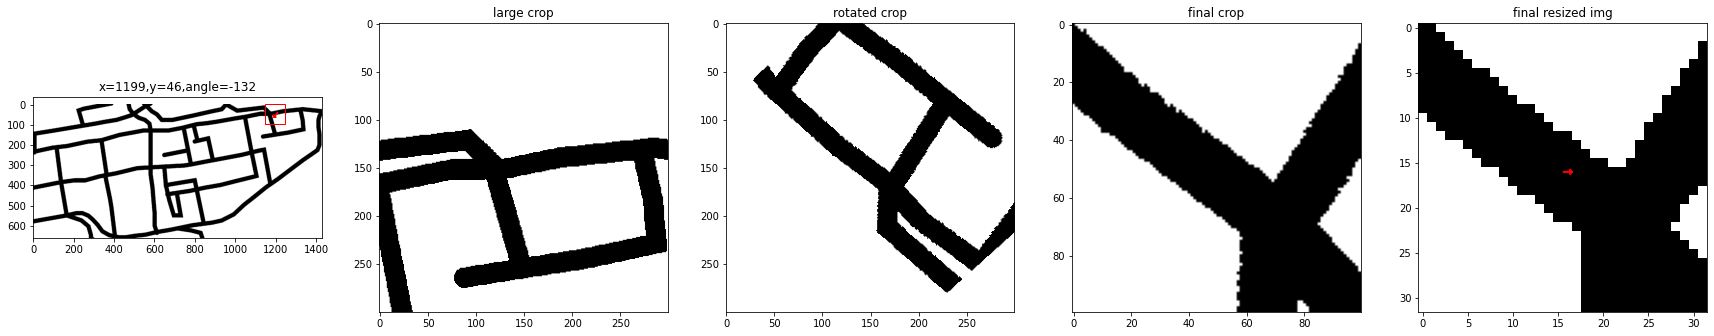

>>> tensor([ 0.5553,  0.4413, -0.4413]) [1199, 46] -132 [19.97474027]
>>> tensor([ 0.5509, -0.8413,  0.8413]) [1193.8564345351097, 58.29282939323171] 1796.3939808344542 [19.7330911]
>>> tensor([ 0.5511, -0.1364,  0.1364]) [1193.9310146826342, 56.90996836462297] 3723.3514475956745 [19.32133407]
>>> tensor([ 0.5492,  0.5690, -0.5690]) [1190.9781926716557, 57.19692138462418] 5650.209296933785 [19.75336306]
>>> tensor([ 0.5491, -0.7590,  0.7590]) [1191.106561911271, 59.32353292427408] 7571.0667138776225 [19.74904444]
>>> tensor([ 0.5487, -0.0629,  0.0629]) [1190.3135827354927, 57.76512928248008] 9496.425148194132 [19.22864051]
>>> tensor([ 0.5470,  0.5931, -0.5931]) [1187.578008687123, 58.54392747699057] 11414.381279349247 [19.7787401]
>>> tensor([ 0.5469, -0.7318,  0.7318]) [1187.7556995781506, 60.162336226552426] 13335.826297131247 [20.]
>>> tensor([ 0.5457, -0.0643,  0.0643]) [1186.288730582445, 63.132235731448944] 15255.79025216497 [19.09956672]
>>> tensor([ 0.5453,  0.6259, -0.6259]) 

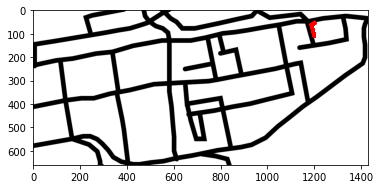

Training took 97.26937437057495 secs



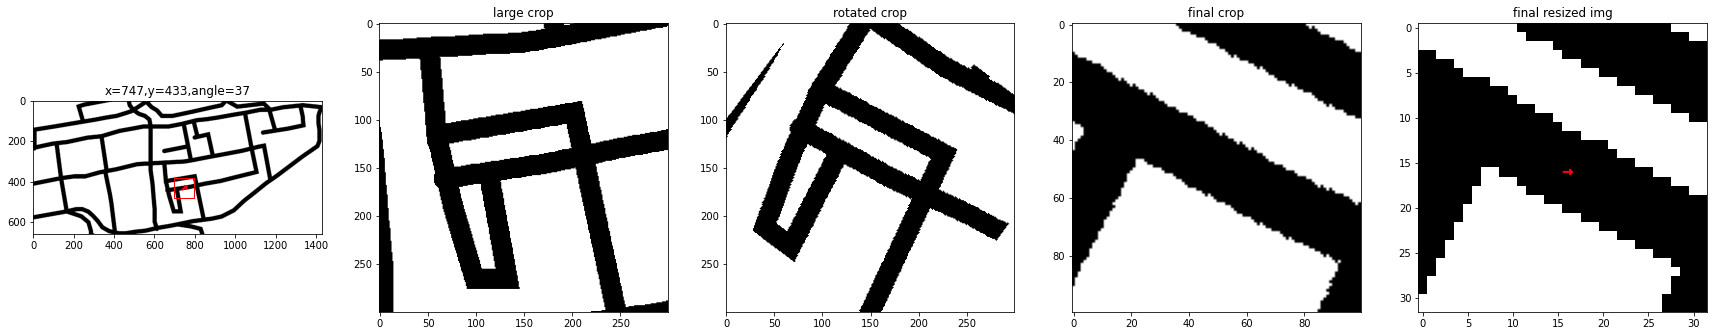

>>> tensor([ 0.3078, -0.4291,  0.4291]) [747, 433] 37 [19.50137985]
>>> tensor([ 0.3123,  0.2574, -0.2574]) [764.1954808810397, 417.7406313073542] 1961.8366120663595 [19.42022279]
>>> tensor([ 0.3158,  0.9152, -0.9152]) [771.752417025981, 415.2154108342374] 3880.697920186395 [20.]
>>> tensor([ 0.3173, -0.3987,  0.3987]) [774.49895042564, 415.33985729857926] 5804.3345832635 [17.69942346]
>>> tensor([ 0.3160,  0.3088, -0.3088]) [773.3786388633265, 412.8966615398744] 7731.689950017202 [18.72669724]
>>> tensor([ 0.3161, -0.9955,  0.9955]) [772.2565117332568, 415.27149634695115] 9656.786700146282 [19.24387535]
>>> tensor([ 0.3173, -0.3508,  0.3508]) [774.7458292133867, 414.78426347758233] 11572.977101059721 [19.0847629]
>>> tensor([ 0.3158,  0.3607, -0.3607]) [773.1880020940804, 412.54078475286633] 13501.026322877877 [19.57349964]
>>> tensor([ 0.3161, -0.9229,  0.9229]) [772.4603535626552, 415.0102148818049] 15429.868397171496 [18.9476096]
>>> tensor([ 0.3171, -0.2007,  0.2007]) [774.906735

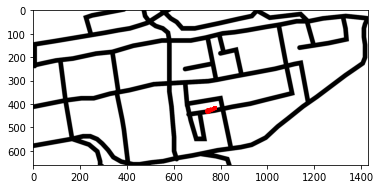

Training took 98.10003805160522 secs



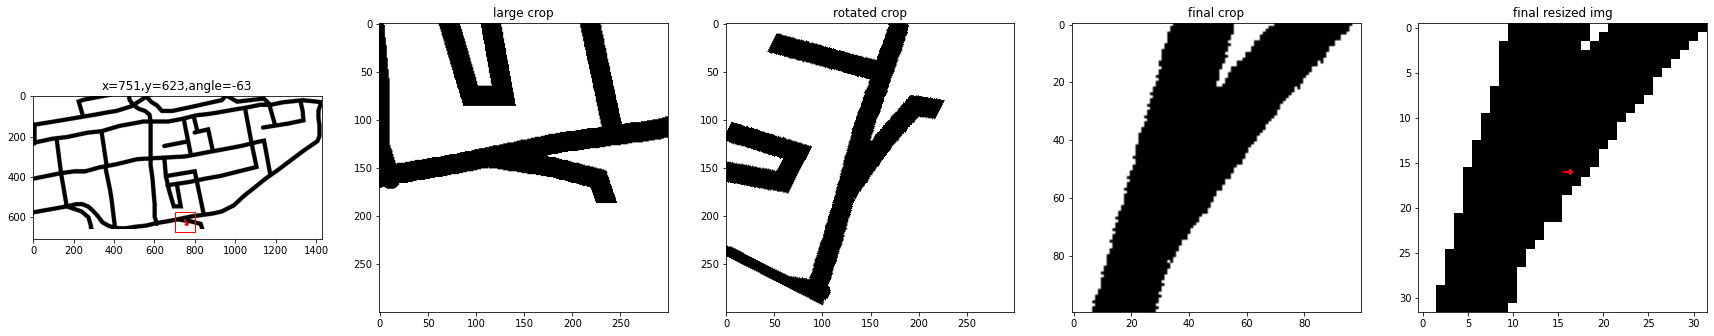

>>> tensor([ 0.3870, -0.9646,  0.9646]) [751, 623] -63 [20.]
>>> tensor([ 0.3882,  0.0059, -0.0059]) [760.6211191913546, 616.4093166063037] 1912.2361387192097 [19.73400259]
>>> tensor([ 0.3862,  0.9572, -0.9572]) [750.3841825702845, 621.8800967788181] 3882.914459580135 [19.88154652]
>>> tensor([ 0.3889, -0.0469,  0.0469]) [761.4167601238395, 617.0949005765237] 5862.7621903683485 [20.]
>>> tensor([ 0.3857,  0.9135, -0.9135]) [750.2243716279288, 620.9533467842384] 7835.051486596128 [19.60565885]
>>> tensor([ 0.3897, -0.1366,  0.1366]) [761.4022744562162, 618.8791479992466] 9806.591703296794 [19.97365224]
>>> tensor([ 0.3846,  0.8375, -0.8375]) [749.4283393663327, 619.2733179393676] 11781.369584254999 [19.56837766]
>>> tensor([ 0.3896, -0.1838,  0.1838]) [761.0724321610332, 619.1008558884596] 13758.078512011452 [19.95496151]
>>> tensor([ 0.3843,  0.8105, -0.8105]) [749.6521680182212, 618.4987351875989] 15736.531118506267 [20.]
>>> tensor([ 0.3900, -0.2124,  0.2124]) [761.4035568968156, 61

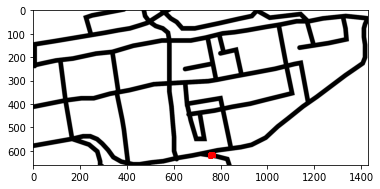

Training took 477.60938262939453 secs



In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt

max_timesteps = 500000
start_time = time.time()
path = []
x = np.array([])
y = np.array([])
# We start the main loop over 500,000 timesteps
while total_timesteps < max_timesteps:
  
  # If the episode is done
  if done:
    # If we are not at the very beginning, we start the training process of the model
    if total_timesteps != 0:
      print("Total Timesteps: {} Episode Num: {} Episode Len: {} Reward: {} Time Taken: {} secs".format(
              total_timesteps, episode_num, episode_timesteps,
              episode_reward, time.time() - start_time))
      print("Rewards Distribution: ", sorted(env.rewards_distribution.items()))

      # Plot the path taken in an episode
      im = plt.imread(env.filename)
      implot = plt.imshow(im)
      p_x, p_y = map(list,zip(*path))
      plt.scatter(p_x,p_y,s=1,c='red')
      plt.show()

      # Reset rewards distribution counter
      env.rewards_distribution = Counter()

      start_time = time.time()
      policy.train(replay_buffer, episode_timesteps, batch_size, discount, tau, policy_noise, noise_clip, policy_freq)
      print("Training took {} secs".format(time.time() - start_time))
      print("")

    # We evaluate the episode and we save the policy
    if timesteps_since_eval >= eval_freq:
      timesteps_since_eval %= eval_freq
      evaluations.append(evaluate_policy(policy))
      policy.save(file_name, directory="./pytorch_models")
      np.save("./results/%s" % (file_name), evaluations)
      start_time = time.time()
    
    # When the training step is done, we reset the state of the environment
    obs = env.reset()
    x = np.append(x, env.pos.x)
    y = np.append(y, env.pos.y)

    # Set the Done to False
    done = False
    
    # Set rewards and episode timesteps to zero
    episode_reward = 0
    episode_timesteps = 0
    episode_num += 1
    path = [(env.pos.x, env.pos.y)]
  
  if total_timesteps == start_timesteps:
    # Plot the distribution of the points covered during initial start_timesteps
    im = plt.imread(env.filename)
    implot = plt.imshow(im)
    plt.scatter(x,y, s=10,c='red')
    plt.show()
  # Before 10000 timesteps, we play random actions
  if total_timesteps < start_timesteps:
    action = env.random_action()
  else: # After 10000 timesteps, we switch to the model
    action = policy.select_action(obs)
    # If the explore_noise parameter is not 0, we add noise to the action and we clip it
    is_noise = False
    if expl_noise != 0:
      is_noise = True
      action = (action + np.random.normal(0, expl_noise, size=env.action_dim)).clip(-env.max_angle, env.max_angle)
  if episode_timesteps % 100 == 0:
    if episode_timesteps == 0:
      env.render()
    print(">>>", obs[1], env.pos, env.angle, action)
  
  # The agent performs the action in the environment, then reaches the next state and receives the reward
  new_obs, reward, done = env.step(action)
  path.append((env.pos.x, env.pos.y))

  # We check if the episode is done
  if episode_timesteps + 1 == env._max_episode_steps:
    done = True
  done_bool = 0 if episode_timesteps + 1 == env._max_episode_steps else float(done)
  
  # We increase the total reward
  episode_reward += reward
  # We store the new transition into the Experience Replay memory (ReplayBuffer)
  replay_buffer.add((obs[0], obs[1], new_obs[0], new_obs[1], action, reward, done_bool))

  # Since the car might get stuck in a loop,
  # better to stop when we reach a threshold of negative reward
  if episode_reward < -3000:
    done = True
  # We update the state, the episode timestep, the total timesteps,
  # and the timesteps since the evaluation of the policy
  obs = new_obs
  episode_timesteps += 1
  total_timesteps += 1
  timesteps_since_eval += 1

# We add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

In [0]:

import numpy as np
import matplotlib.pyplot as plt
im = plt.imread("MASK1.png")
implot = plt.imshow(im)
plt.scatter(x,y)
plt.show()

In [0]:
# init
x, y, angle = 1169, 407, -90
env = CarEnv("MASK1.png")
env.pos.x = x
env.pos.y = y
env.angle = angle
#env.target = Vector(1200,600)

policy = T3D(state_dim, action_dim, max_action)
policy.load(file_name, './pytorch_models/')

done = False
x = np.array([])
y = np.array([])
while not done:
  obs = env.get_state()
  env.render()
  x = np.append(x, env.pos.x)
  y = np.append(y, env.pos.y)
  angle = policy.select_action(obs)
  new_obs, reward, done = env.step(angle)
  #print(obs)
  print(env.pos, env.angle, angle, env.velocity)  

import numpy as np
import matplotlib.pyplot as plt
im = plt.imread("MASK1.png")
implot = plt.imshow(im)
plt.scatter(x,y)
plt.show()